In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use('default')

# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid
from GRF_perturbations.Modules.GRF_generation import get_k_grid,nonsingular_Power_spectrum

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Statistics of anomalies power spectrum

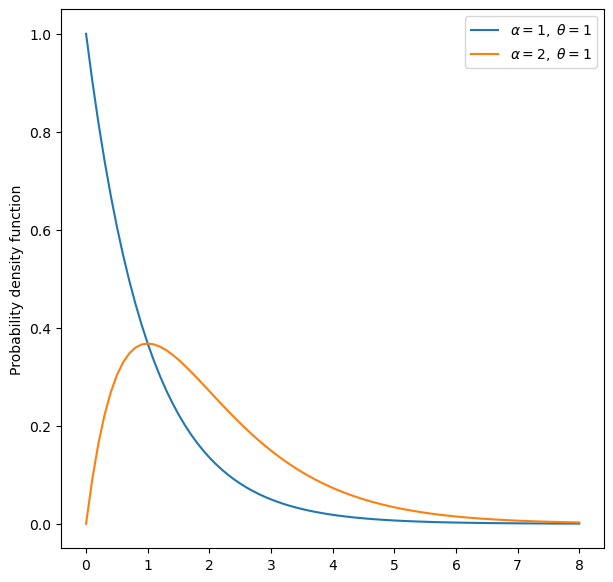

In [4]:
from scipy.stats import gamma,lognorm
plt.figure(figsize=(7,7))
x=np.linspace(0,8,81)

plt.plot(x,gamma.pdf(x,1,0,1),label=r'$\alpha=1, \ \theta=1$')
plt.plot(x,gamma.pdf(x,2,0,1),label=r'$\alpha=2, \ \theta=1$')
plt.legend()
plt.ylabel('Probability density function')
plt.show()

In [5]:
Spectral_dof=2*np.ones((100,100))
Spectral_dof[0,0]=1
Spectral_dof[0,50]=1
Spectral_dof[50,0]=1
Spectral_dof[50,50]=1
Spectral_dof=Spectral_dof[:,:51]

In [6]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
k_vector=np.fft.fftfreq(100,0.08)
kx,ky=np.meshgrid(k_vector,k_vector)
kx=kx[:,:51]
ky=ky[:,:51]
k_reduced_grid=k_grid[:,:51]

init_freq_index=4
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125)
#k_values=np.logspace(np.log10(0.5),np.log10(6.25),300)
Ring_masks=np.zeros((len(k_values)-init_freq_index,k_reduced_grid.shape[0],k_reduced_grid.shape[1]),dtype=bool)
Gamma_shapes=np.zeros(len(k_values)-init_freq_index)

for i in range(init_freq_index,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i-init_freq_index]=np.logical_and((k_reduced_grid>=k_values[i-1]),(k_reduced_grid<k_values[i]))
        Gamma_shapes[i-init_freq_index]=Spectral_dof[Ring_masks[i-init_freq_index]].sum()/2

In [7]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

In [14]:
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase
Anomalies_spectra=np.zeros((1000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(1000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,True,noise_seed)
    Anomalies_images=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft2(Anomalies_images))**2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.42it/s]


In [15]:
Radial_spectra=np.array([ np.array([((Anomalies_spectra[j,:,:51])[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))]) for j in tqdm(range(1000))])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2364.75it/s]


Text(0.5, 1.0, 'Power spectrum $P_{\\delta I}$')

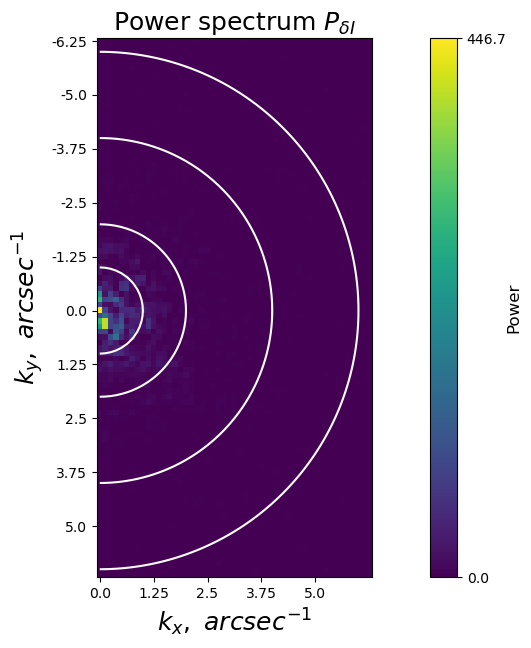

In [18]:
#spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.fft.fftshift(Anomalies_spectra[0,:,:51],axes=0)
fig=plt.figure(figsize=(15,7))

img=power_spec
im=plt.imshow(power_spec)

ks=np.fft.fftshift(k_grid)[:,50:]

plt.contour(ks,[1,2,4,6],colors='w')

plt.xticks(np.arange(0,50,10),kx[0,:50][::10])
plt.xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
plt.yticks(np.arange(0,100,10),np.fft.fftshift(ky[:,0])[::10])
plt.ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)

cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Power',rotation=90,fontsize=12,labelpad=0)

plt.title('Power spectrum '+r'$P_{\delta I}$',fontsize=FS)

In [1]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

#kx=1, ky=0
plt.hist(Anomalies_spectra[:,0,index_freq],bins=100,density=True,\
         label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(k_values[index_freq])+r'$,k_y=0)$',alpha=0.3)

x=np.linspace(0,Anomalies_spectra[:,0,index_freq].max(),100)
plt.plot(x,gamma.pdf(x,1,0,single_scale),label='Gamma distribution',linestyle='--',linewidth=2,color='C0')


#2<=k<2.125
aggregated_spectra=(Anomalies_spectra[:,:,:51]*Ring_masks[index_rad]).sum(axis=(1,2))/(Ring_masks[index_rad].sum())
shape_marg=Ring_masks[index_rad].sum()

plt.hist(aggregated_spectra,bins=50,density=True,label=r'$<P_{\delta I}(|k|)>_{k \in [2,2.125)}$',color='C1',alpha=0.3)

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])

x=np.linspace(0,aggregated_spectra.max(),100)
plt.plot(x,lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',linewidth=2,color='C1')



plt.xlim(0,15)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

# Surface brightness anomalies in the lensed images

In [4]:
get_GRF=Inference.GRF_getters(True)
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
zero_mean_mask=np.ones_like(nonsingular_k_grid)
zero_mean_mask[0,0]=0

GRF_params=[-7,2]
PS=nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid)
k_vector=np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
kx,ky=np.meshgrid(k_vector,k_vector)

xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates
ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0

In [5]:
GRF_params=[-7,2]
get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF([-7,3],1)
initial=deepcopy(GRF_potential)

Text(0, 0.5, 'arcsec')

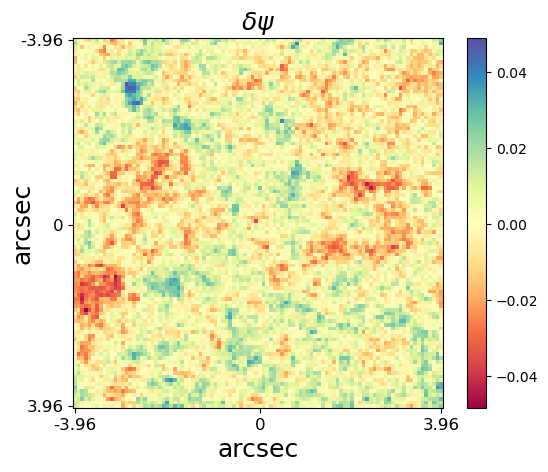

In [6]:
fig,axis=plt.subplots(1,1)
GRF_potential=get_GRF([-7,2],4)
img=axis.imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
fig.colorbar(img,ax=axis)
axis.set_title(r'$\delta \psi$',fontsize=FS)


    #axis.set_title(titles[i],fontsize=FS)
axis.set_xticks([0,50,100-1])
axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
axis.set_yticks([0,50,100-1])
axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
axis.set_xlabel('arcsec',fontsize=FS)
axis.set_ylabel('arcsec',fontsize=FS,labelpad=-10)

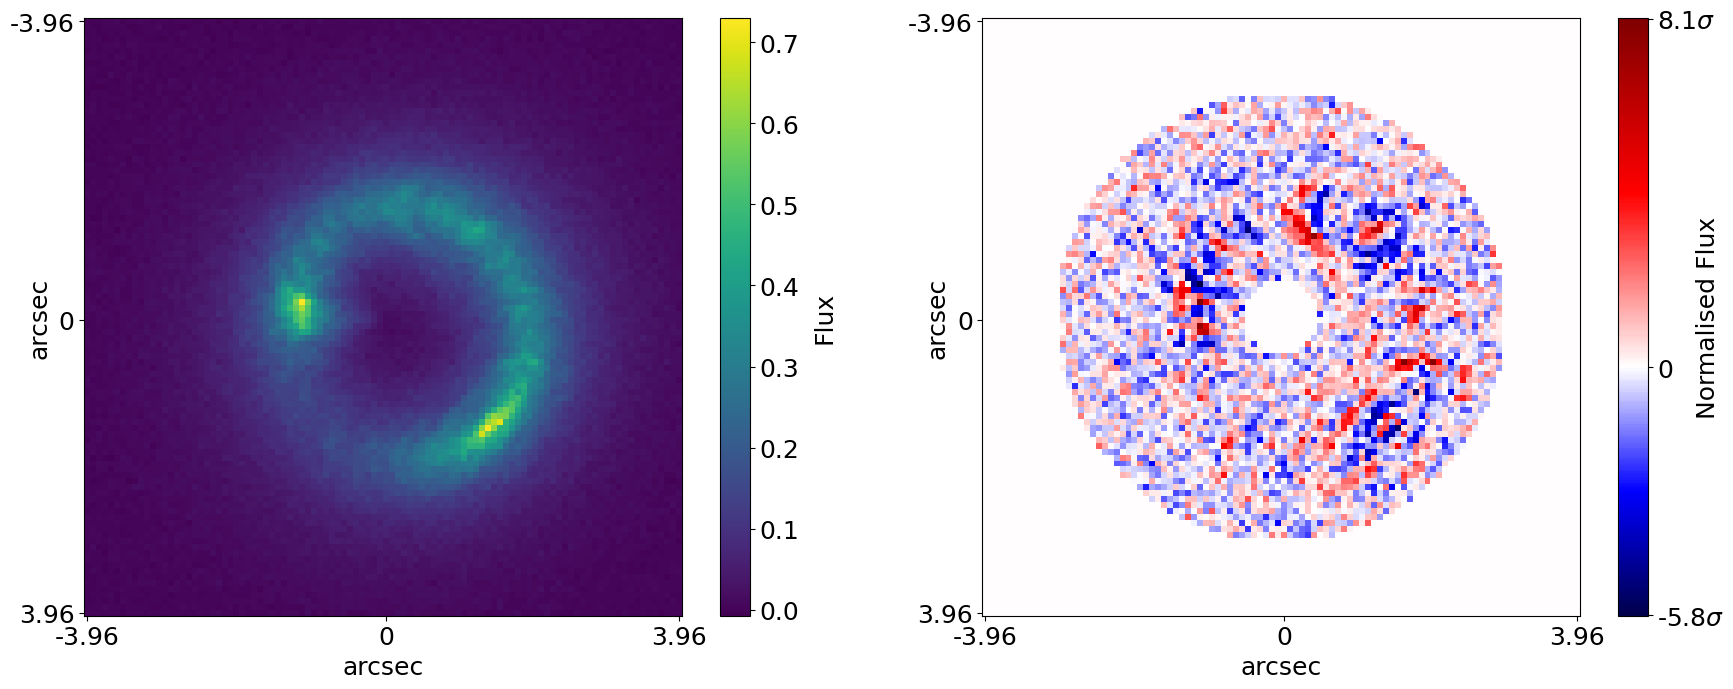

In [7]:
GRF_params=[-7.6,2.]
GRF_seed_index=2

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

normalised_masked_residuals=((simulated_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,2,figsize=(18,7))

img_arr=[]

img_arr+=[ax[0].imshow(simulated_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[1].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[1],ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    #axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=FS)
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=FS)
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS,labelpad=-30)

plt.tight_layout()
#plt.show()

In [10]:
ra_at_xy_0

-3.96

In [8]:
!ls

Figures_for_paper.ipynb         Likelihood.ipynb
GRF region restriction.ipynb    Paper_figures.ipynb
Generation_GRF_test.ipynb       Prediction_metaanalysis.ipynb
Generation_Inference_test.ipynb Presentation_figures.ipynb
Grid_generation.ipynb           data
Grid_processing.ipynb           starting_guide.ipynb
Inference_test.ipynb


In [9]:
#np.save('./data/Observation example.npy',simulated_image)

In [35]:
k_grid, _ = get_k_grid(Observation_conditions.pixel_number, Observation_conditions.pixel_scale)
radial_spectrum = compute_radial_spectrum(simulated_image-Image_unperturbed_noiseless, Observation_conditions.annulus_mask, k_grid,
                                              Observation_conditions.frequencies)

([<matplotlib.axis.YTick at 0x28abd1340>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

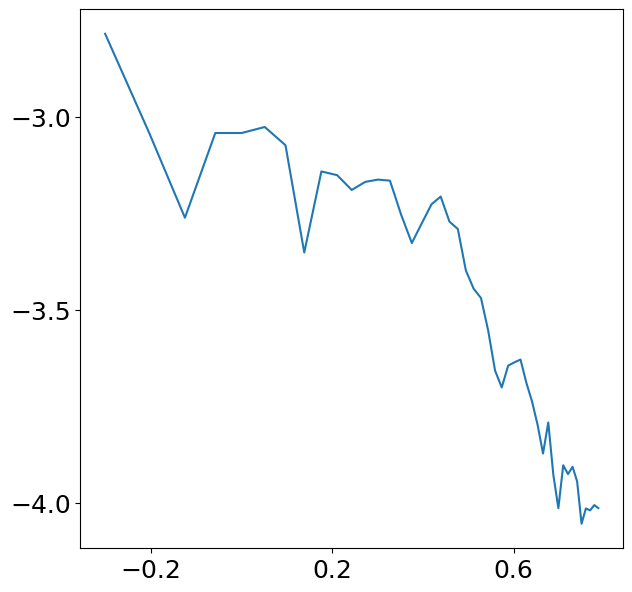

In [47]:
fig=plt.figure(figsize=(7,7))
plt.plot(np.log10(Observation_conditions.frequencies),np.log10(radial_spectrum))
plt.xticks([-0.2,0.2,0.6],fontsize=FS)
plt.yticks([-4,-3.5,-3],fontsize=FS)

([], [])

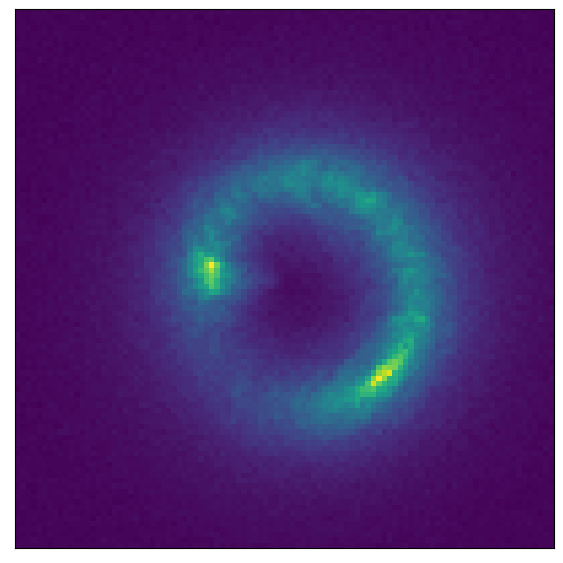

In [51]:
fig=plt.figure(figsize=(7,7))
plt.imshow(simulated_image)
plt.xticks([])
plt.yticks([])

([], [])

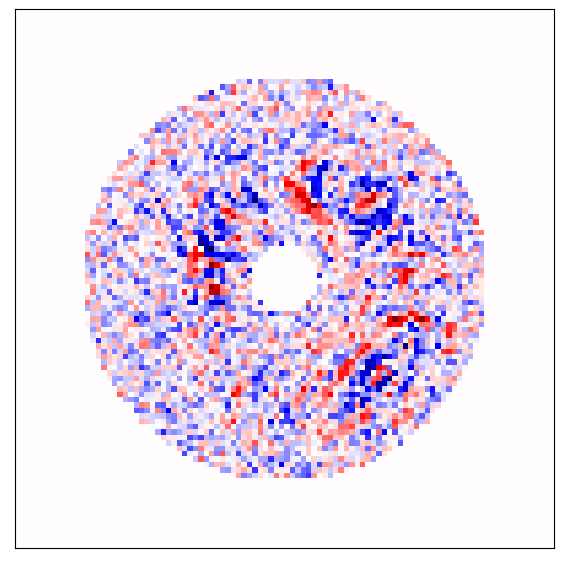

In [52]:
fig=plt.figure(figsize=(7,7))
plt.imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.xticks([])
plt.yticks([])

# Performance test on border cases

In [27]:
grid_size=128
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

In [28]:
Spectra_grid=np.load('../Processing_scripts/results/Radial_spectra/Spectra_grid.npz')['arr_0']

In [29]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:227: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [30]:
MU_tensor=np.log(Spectra_grid).mean(axis=2)
MU_tensor_ext=np.tile(MU_tensor,GRF_seeds_number)
MU_tensor_ext=MU_tensor_ext.reshape((grid_size,grid_size,GRF_seeds_number,Spectra_grid.shape[-1]))
Sigma_tensor=np.sqrt(np.power(np.log(Spectra_grid)-MU_tensor_ext,2).sum(axis=2)/(Spectra_grid.shape[2]-1))

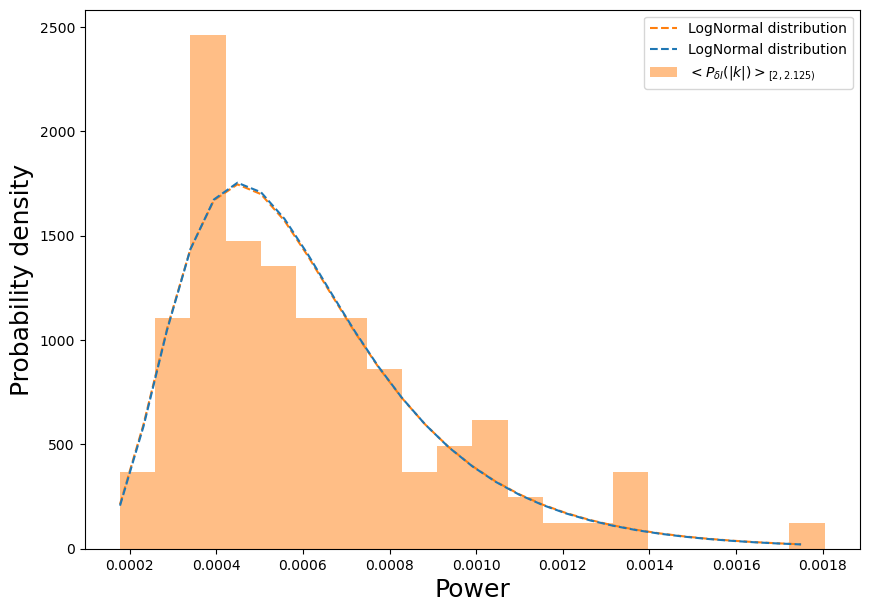

In [8]:
from scipy.stats import gamma,lognorm
import scipy as sc
plt.figure(figsize=(10,7))


index_freq=4
index_rad=index_freq+1-4

index_A=95
index_B=50

data=Spectra_grid[index_A,index_B,:,index_rad]

#1<=k<1.125
distr_marg,x_marg=np.histogram(data,bins=30,density=True)
plt.hist(data,bins=20,density=True,label=r'$<P_{\delta I}(|k|)>_{[2,2.125)}$',color='C1',alpha=0.5)

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(data)
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C1')

#LN_mu=np.log(data).mean()
#LN_sigma=np.sqrt(np.power(np.log(data)-LN_mu,2).sum()/(len(data)-1))

LN_mu=MU_tensor[index_A,index_B,index_rad]
LN_sigma=Sigma_tensor[index_A,index_B,index_rad]
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C0')

plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

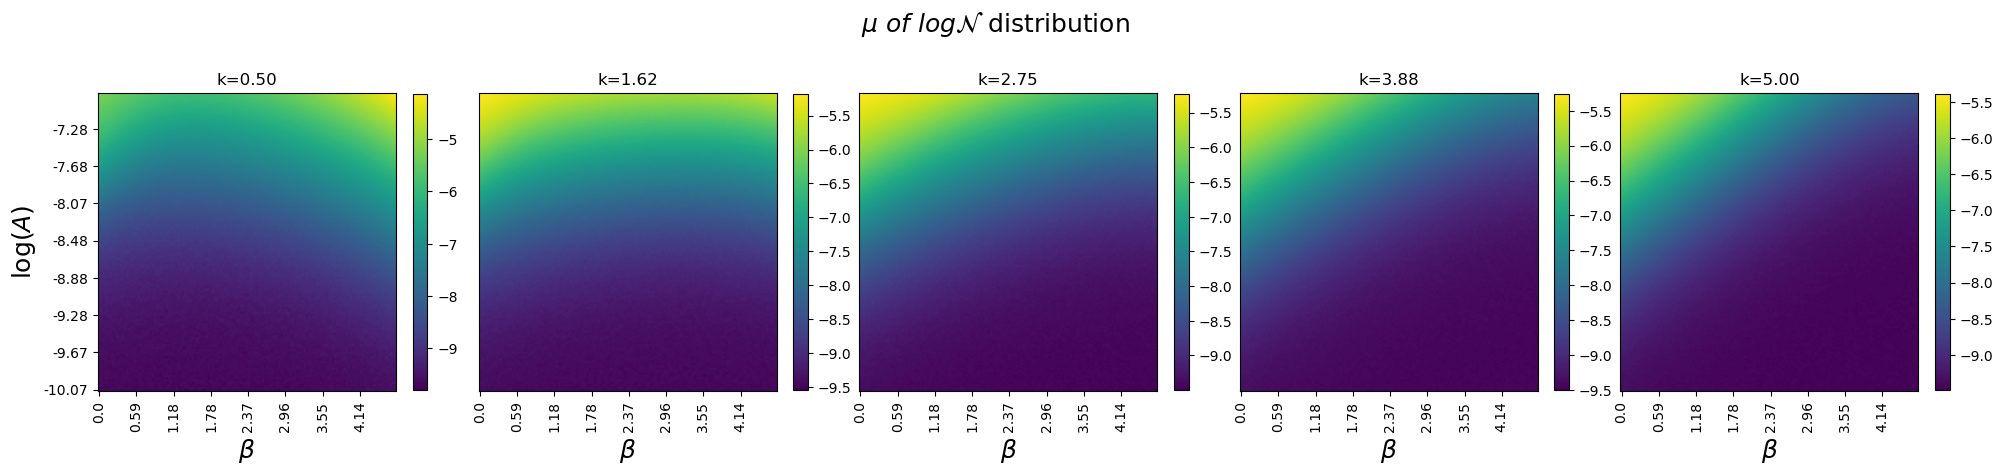

In [9]:
size=5
fig,ax=plt.subplots(1,size,figsize=(20,7))

step=MU_tensor.shape[-1]//size
reduced_tensor=MU_tensor[:,:,::size]
for i in range(size):  
    axis=ax[i]
    
    img=axis.imshow(reduced_tensor[:,:,i])
    fig.colorbar(img,ax=axis,fraction=0.045)
    
    axis.set_xticks(np.arange(0,128,16))
    axis.set_xticklabels(Beta_array[::16].round(2),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=FS)
    
    axis.invert_yaxis()
    
    axis.set_title('k={:.2f}'.format(Observation_conditions.frequencies[i*step]))
    
    if i==0:
        axis.set_ylabel(r"${\rm log}(A)$",fontsize=FS)
        axis.set_yticks(np.arange(0,128,16))
        axis.set_yticklabels(logA_array[::16].round(2))
    else:
        axis.set_yticks([])
      
fig.suptitle(r'$\mu \ of\ log\mathcal{N}$'+' distribution',fontsize=FS,y=0.8)
fig.tight_layout()
plt.show()

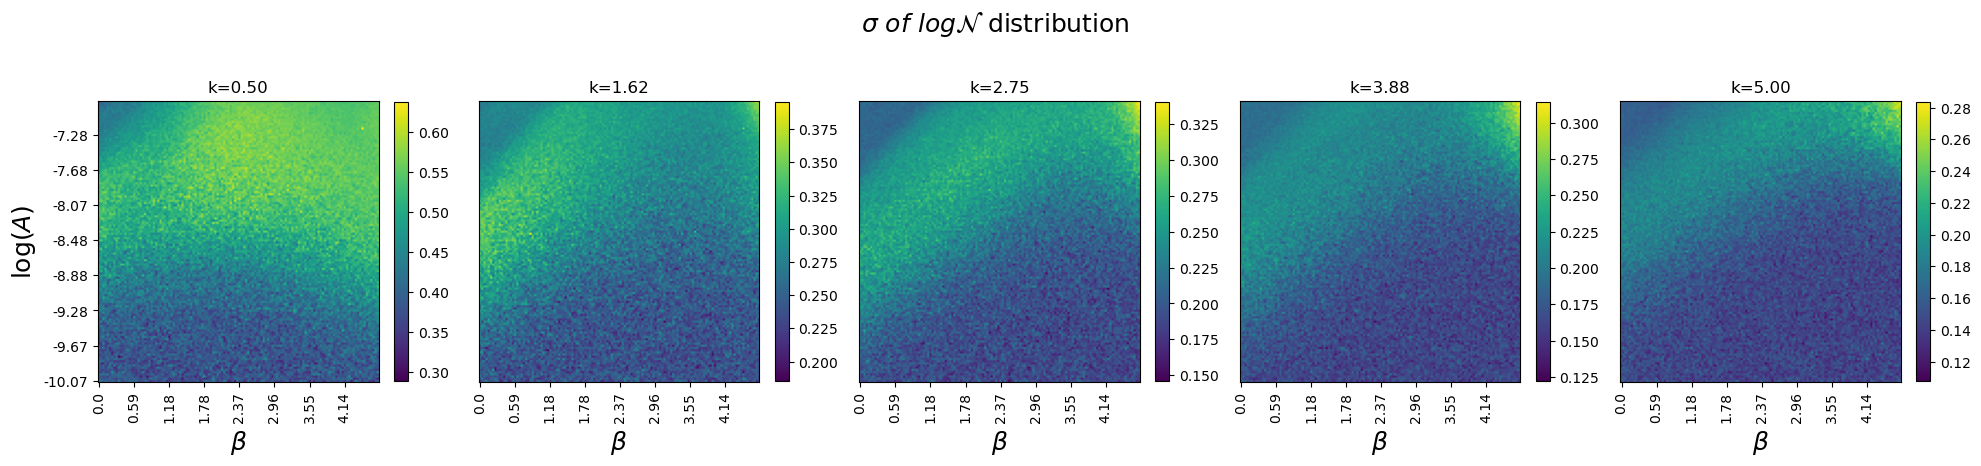

In [15]:
size=5
fig,ax=plt.subplots(1,size,figsize=(20,7))

step=Sigma_tensor.shape[-1]//size
reduced_tensor=Sigma_tensor[:,:,::size]
for i in range(size):  
    axis=ax[i]
    
    img=axis.imshow(reduced_tensor[:,:,i])
    fig.colorbar(img,ax=axis,fraction=0.045)
    
    axis.set_xticks(np.arange(0,128,16))
    axis.set_xticklabels(Beta_array[::16].round(2),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=FS)
    
    axis.invert_yaxis()
    
    axis.set_title('k={:.2f}'.format(Observation_conditions.frequencies[i*step]))
    
    if i==0:
        axis.set_ylabel(r"${\rm log}(A)$",fontsize=FS)
        axis.set_yticks(np.arange(0,128,16))
        axis.set_yticklabels(logA_array[::16].round(2))
    else:
        axis.set_yticks([])
      
fig.suptitle(r'$\sigma \ of\ log\mathcal{N}$'+' distribution',fontsize=FS,y=0.8)
fig.tight_layout()
plt.show()

In [31]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    



def conduct_inference(GRF_params,GRF_seed_index):
    get_GRF=Inference.GRF_getters(True)
    GRF_potential=get_GRF(GRF_params,GRF_seed_index)

    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

    simulate_perturbed_image=Observation_conditions.perturbed_image_getter
    simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)
    
    args_fit=Inference.differentiable_fit_image(simulated_image)

    simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
    fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

    residuals=simulated_image-fit_image
    spectrum=Inference.compute_radial_spectrum(residuals)

    true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
    true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

    likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,logA_conf_regions,Beta_conf_regions=Inference_pipeline(spectrum,MU_tensor,Sigma_tensor)
    logA_maxL_index,Beta_maxL_index=jnp.unravel_index(jnp.argmax(likelihood),likelihood.shape)
    
    return GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index

In [32]:
results_low_SNR=conduct_inference([-8.7,2],1)

In [10]:
results_high_SNR=conduct_inference([-7.5,2],2)

In [11]:
results_low_Beta=conduct_inference([-8.21,0.5],0)

In [12]:
#5,9
results_high_Beta=conduct_inference([-7.3,3.5],9)

In [47]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
    conduct_inference([-10,2],1)



In [39]:
logA_array[]

array([-10.075, -10.05 , -10.025, -10.   ,  -9.975,  -9.95 ,  -9.925,
        -9.9  ,  -9.875,  -9.85 ,  -9.825,  -9.8  ,  -9.775,  -9.75 ,
        -9.725,  -9.7  ,  -9.675,  -9.65 ,  -9.625,  -9.6  ,  -9.575,
        -9.55 ,  -9.525,  -9.5  ,  -9.475,  -9.45 ,  -9.425,  -9.4  ,
        -9.375,  -9.35 ,  -9.325,  -9.3  ,  -9.275,  -9.25 ,  -9.225,
        -9.2  ,  -9.175,  -9.15 ,  -9.125,  -9.1  ,  -9.075,  -9.05 ,
        -9.025,  -9.   ,  -8.975,  -8.95 ,  -8.925,  -8.9  ,  -8.875,
        -8.85 ,  -8.825,  -8.8  ,  -8.775,  -8.75 ,  -8.725,  -8.7  ,
        -8.675,  -8.65 ,  -8.625,  -8.6  ,  -8.575,  -8.55 ,  -8.525,
        -8.5  ,  -8.475,  -8.45 ,  -8.425,  -8.4  ,  -8.375,  -8.35 ,
        -8.325,  -8.3  ,  -8.275,  -8.25 ,  -8.225,  -8.2  ,  -8.175,
        -8.15 ,  -8.125,  -8.1  ,  -8.075,  -8.05 ,  -8.025,  -8.   ,
        -7.975,  -7.95 ,  -7.925,  -7.9  ,  -7.875,  -7.85 ,  -7.825,
        -7.8  ,  -7.775,  -7.75 ,  -7.725,  -7.7  ,  -7.675,  -7.65 ,
        -7.625,  -7.

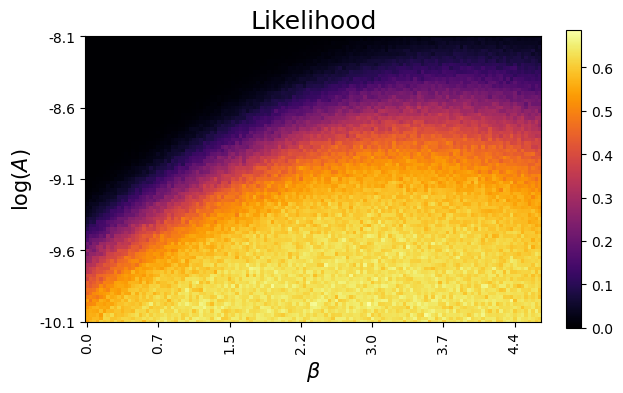

In [52]:
fig,axis=plt.subplots(1,1)
img=axis.imshow(likelihood,cmap='inferno')
axis.set_title('Likelihood',fontsize=FS)

step=20
axis.set_xticks(np.arange(0,len(Beta_array),step))
axis.set_yticks(np.arange(0,len(logA_array),step))
axis.set_xticklabels(Beta_array[::step].round(1),rotation=90)
axis.set_yticklabels(logA_array[::step].round(1))
axis.set_xlabel(r'$\beta$',fontsize=15)
axis.set_ylabel(r"${\rm log}(A)$",fontsize=15)

axis.invert_yaxis()
axis.set_ylim(0,80)

fig.colorbar(img,ax=axis,fraction=0.03)

In [13]:
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,manual_locations,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image)
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_yticklabels(['0','{:.1f}'.format(math.floor(data_image.max()*100)/100)],fontsize=FS)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=-20)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+3)/1e+3,0,math.floor(GRF_potential.max()*1e+3)/1e+3],fraction=0.045)
    cbar.ax.set_ylabel('Potential',rotation=90,fontsize=FS,labelpad=-20)
    #if (GRF_potential.min()<-0.01) and (GRF_potential.max()>0.01):
    #    cbar.ax.set_yticklabels(['{:.2f}'.format(math.ceil(GRF_potential.min()*1e+3)/1e+3),'0','{:.2f}'.format(math.floor(GRF_potential.max()*1e+3)/1e+3)],fontsize=FS)
    #else:
    cbar.ax.set_yticklabels(['{:.3f}'.format(math.ceil(GRF_potential.min()*1e+3)/1e+3),'0','{:.3f}'.format(math.floor(GRF_potential.max()*1e+3)/1e+3)],fontsize=FS)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,7)*0.5-10
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,manual_locations,legend_flag)
    
    ax_row[3].set_xticklabels(Like_xticks,fontsize=15)
    ax_row[3].set_yticklabels(Like_yticks,fontsize=15)
    ax_row[3].set_ylabel(r"${\rm log}(A)$",fontsize=FS,labelpad=-5)
    
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels(np.array([ra_at_xy_0,0,-ra_at_xy_0]).round().astype(int),fontsize=15)
        ax_row[j].set_xlabel('arcsec',fontsize=FS)
        
        ax_row[j].set_yticks([0,50,100-1])
        ax_row[j].set_yticklabels(np.array([dec_at_xy_0,0,-dec_at_xy_0]).round().astype(int),fontsize=15)
        ax_row[j].set_ylabel('arcsec',labelpad=-3,fontsize=FS)

        
    if titles_flag:
        titles=['Einstein ring\nsurface brightness','Gravitational potential\ninhomogeneities',\
                'Anomalies on\nEinstein ring','Confidence regions of\ninhomogeneities parameters']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)

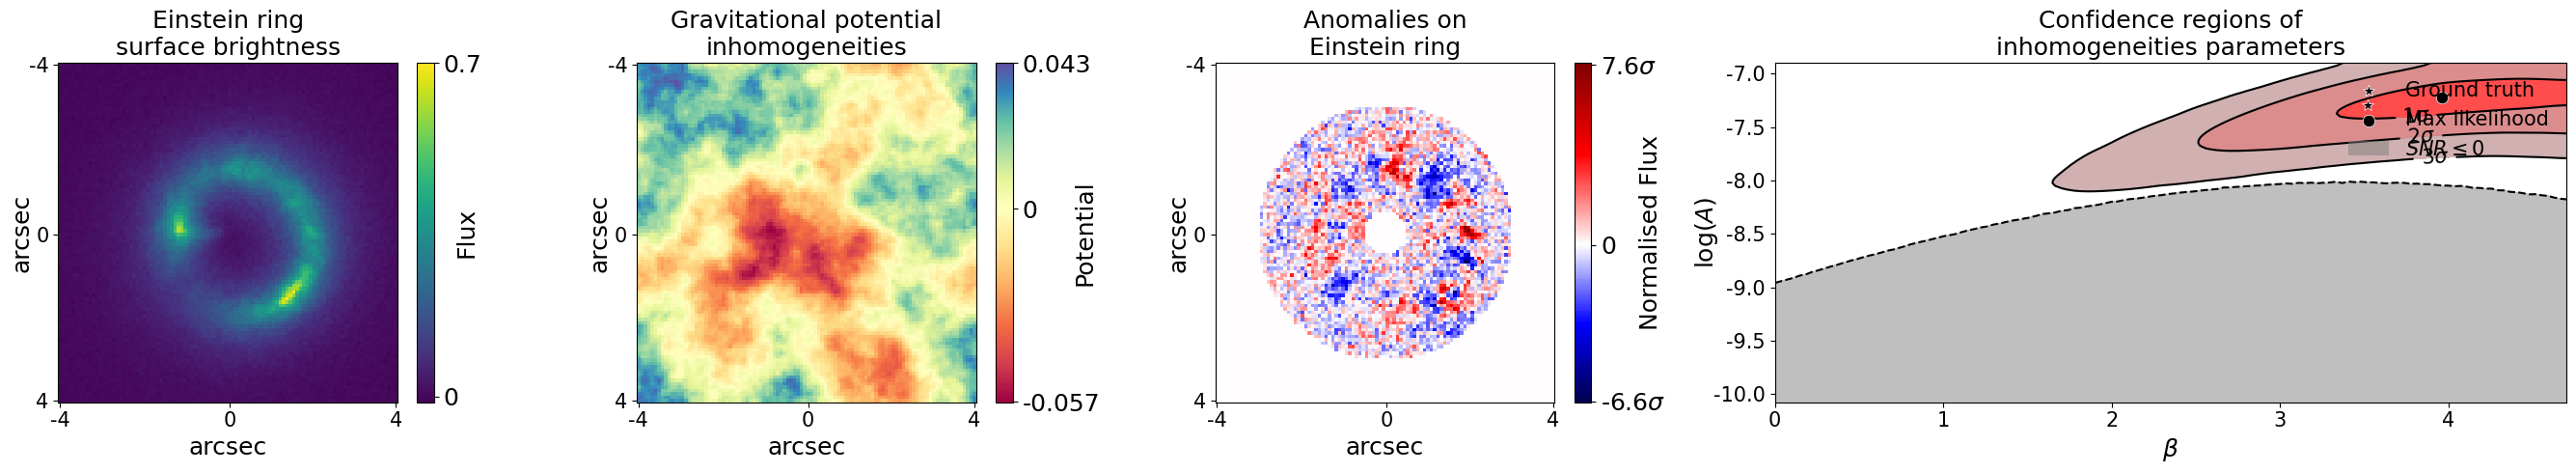

In [14]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
    results_high_Beta


from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

#ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)
ylabel=''

manual_locations=[[(4,-10)],[(4,-10)],[(4,-10)]]
plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,manual_locations,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

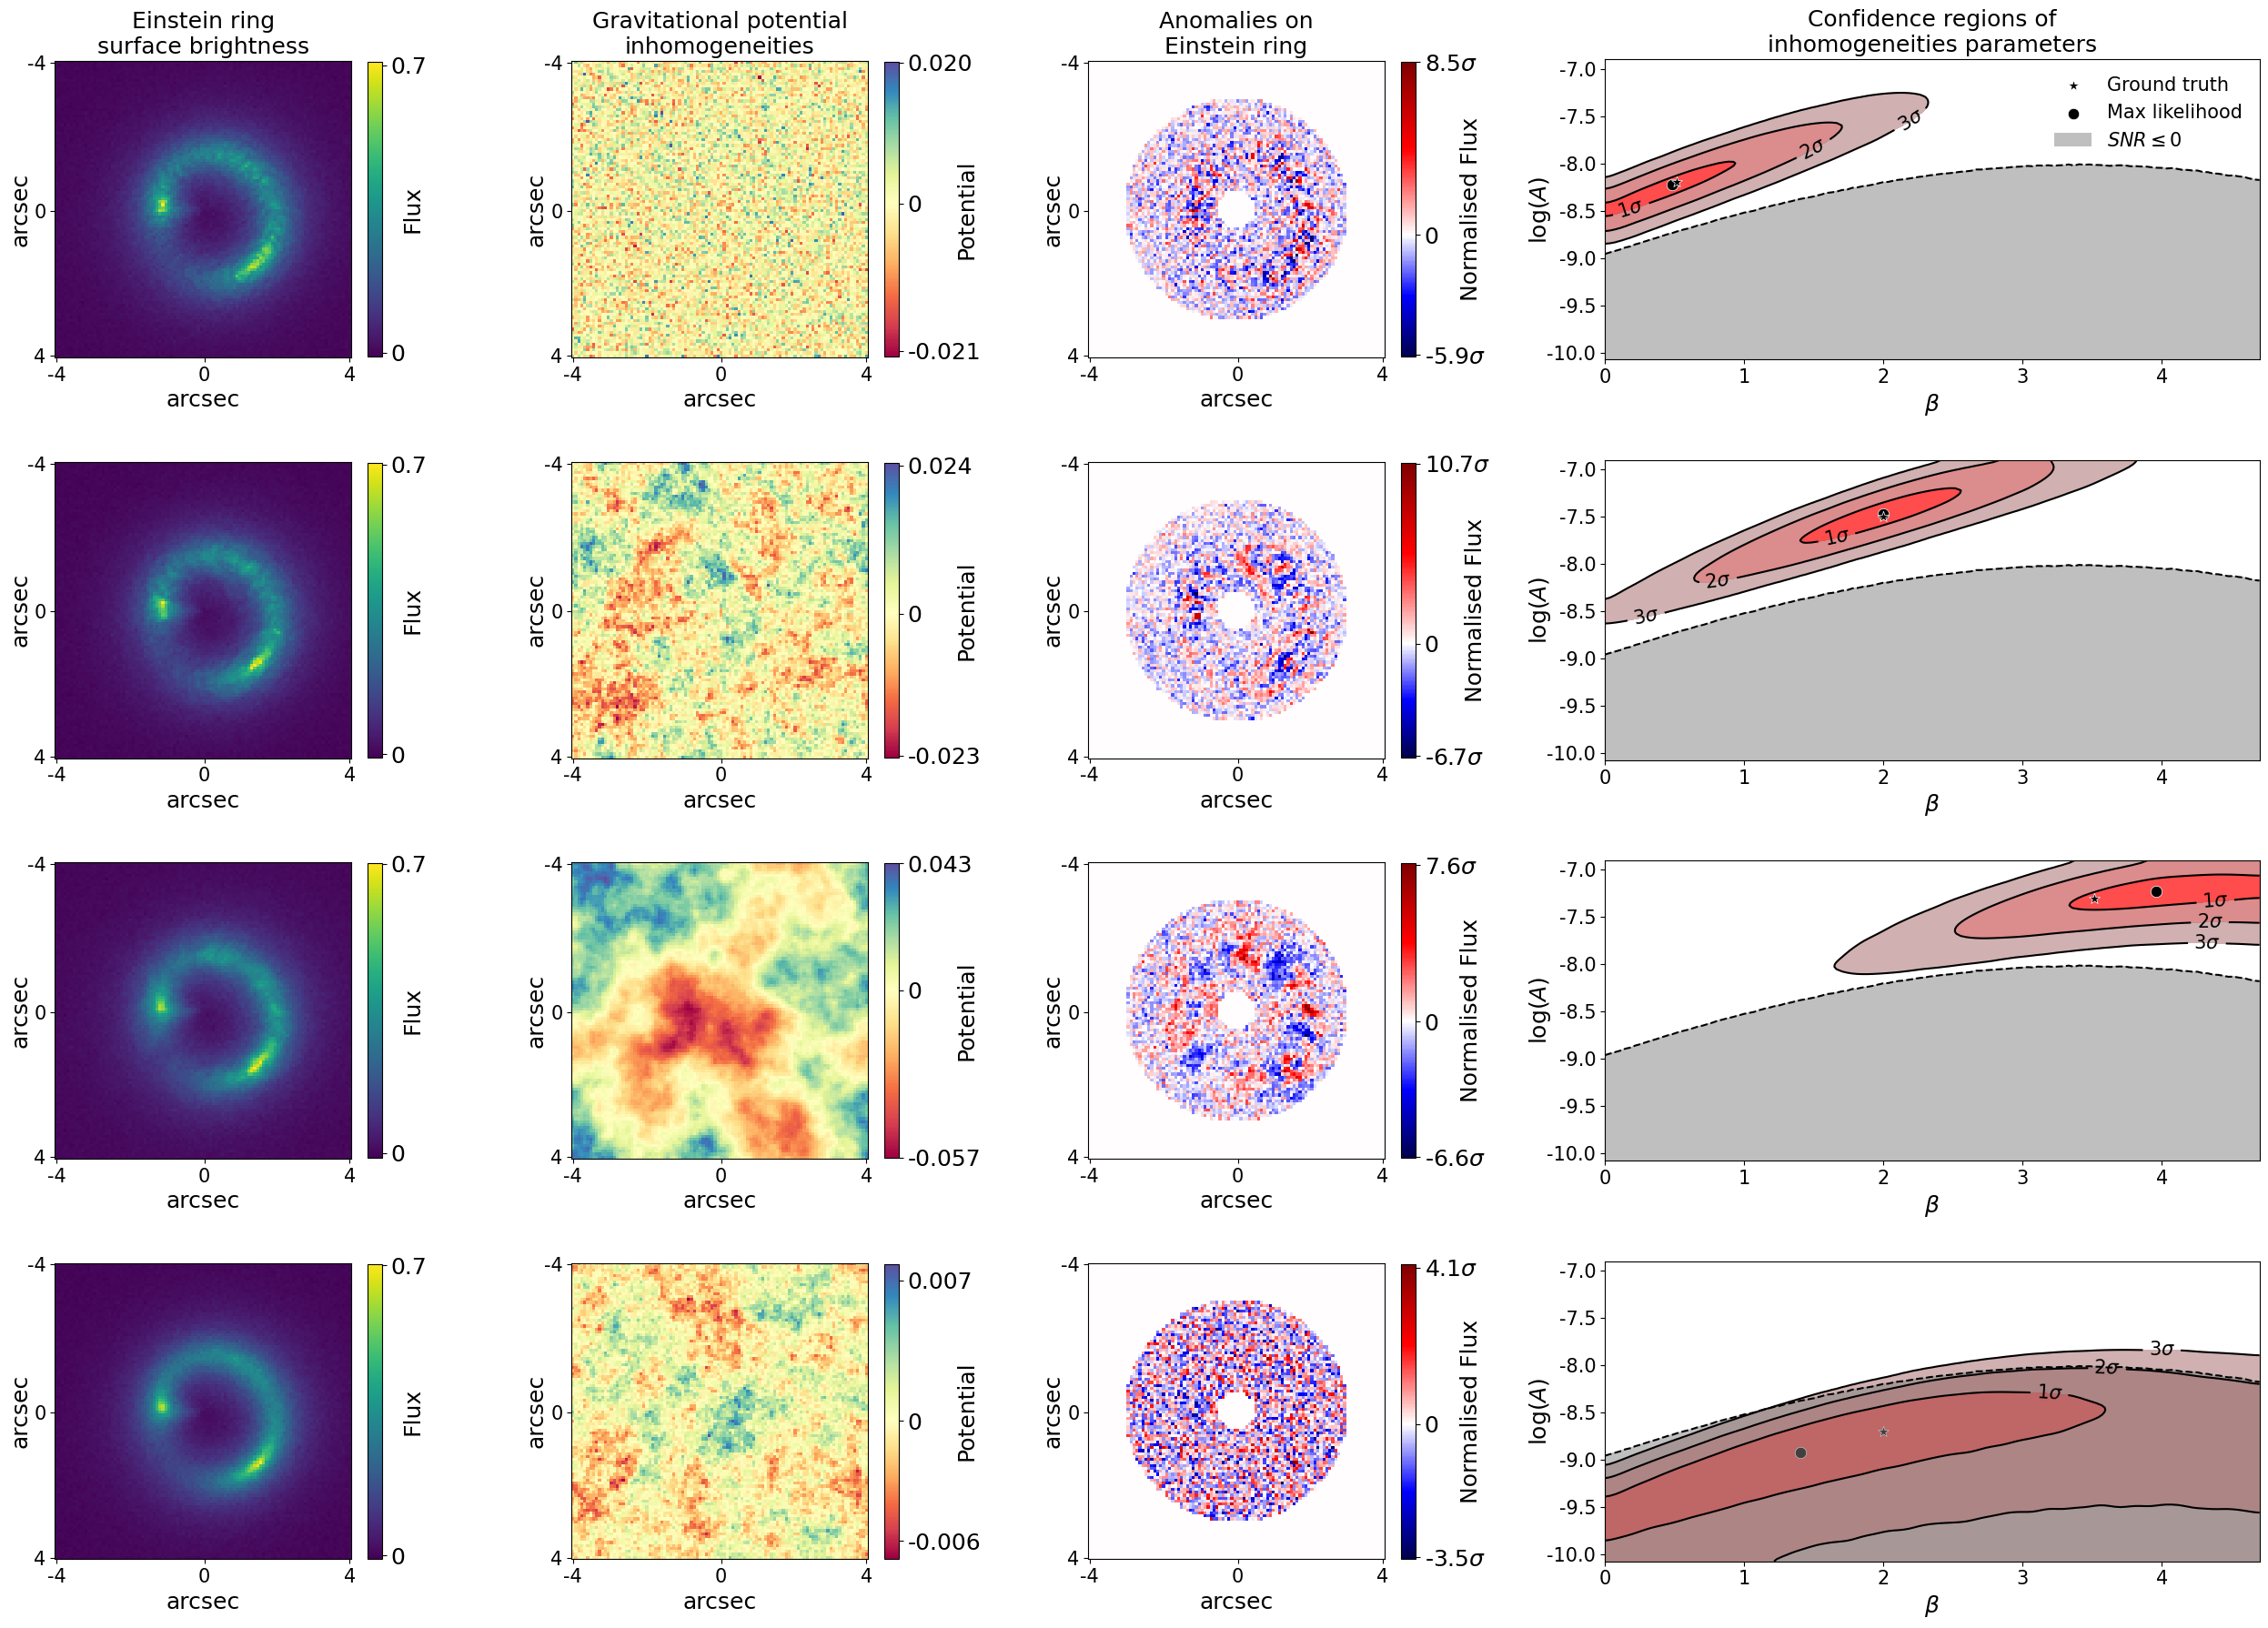

In [15]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta
from matplotlib import gridspec
fig=plt.figure(figsize=(25,18))
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1,1,1,1])
ax=[]
for i in range(4):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

#ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)
ylabel=''

results_array=[results_low_Beta,results_high_SNR,results_high_Beta,results_low_SNR]

#321
contour_labels_locations=[[[(5,-15)],[(4,-15)],[(0.5,-10)]],\
                         [[(1,-14)],[(1,-10)],[(2,-10)]],\
                         [[(4.3,-10)],[(4.35,-10)],[(4.5,-10)]],\
                         [[(4,-10)],[(4,10)],[(4,10)]]]

for i in range(4):
    GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,\
        pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
        results_array[i]
    
    if i==0:
        titles_flag=True
        legend_flag=True
    else:
        titles_flag=False
        legend_flag=False
    
    plot_line(ax[i],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,contour_labels_locations[i],\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=legend_flag,titles_flag=titles_flag)

plt.tight_layout(h_pad=3,w_pad=3)

In [882]:
'''k_grid,nonsingular_k_grid=get_k_grid(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
power_sum_func=np.vectorize(lambda beta: np.power(nonsingular_k_grid,-beta+2).sum())
Amplitudes,Deflection_power_sums=np.meshgrid(power_sum_func(Beta_array),np.power(10,logA_array))
Deflection_variance=Amplitudes*Deflection_power_sums
log_Deflection=np.log10(Deflection_variance)'''

In [16]:
k_vector=np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
kx,ky=np.meshgrid(k_vector,k_vector)

In [17]:
k_grid,nonsingular_k_grid=get_k_grid(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)

power_sum_alphax=np.vectorize(lambda beta: 4*np.pi**2*(np.power(nonsingular_k_grid,-beta)*(kx**2)).sum())
power_sum_alphay=np.vectorize(lambda beta: 4*np.pi**2*(np.power(nonsingular_k_grid,-beta)*(ky**2)).sum())

power_sums=power_sum_alphax(Beta_array)+power_sum_alphay(Beta_array)

Amplitudes,Deflection_power_sums=np.meshgrid(power_sums,np.power(10,logA_array))
Deflection_variance=Amplitudes*Deflection_power_sums
log_Deflection=np.log10(Deflection_variance)

(43.0, 128.0)

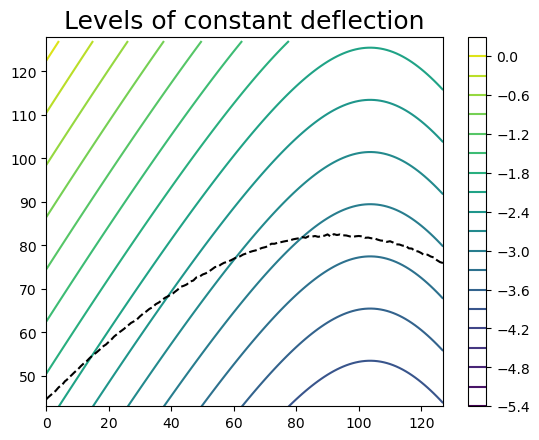

In [214]:
plt.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),log_Deflection,levels=20)
plt.colorbar()
plt.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

plt.title('Levels of constant deflection',fontsize=FS)
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)

In [215]:
#smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid1,sigma=(2,2))
img=plt.contourf(confidence_grid1,[0,0.39347],colors=['red'],alpha=0.7)

#smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid2,sigma=(2,2))
img=plt.contourf(confidence_grid2,[0,0.39347],colors=['red'],alpha=0.7)

#smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid3,sigma=(2,2))
img=plt.contourf(confidence_grid3,[0,0.39347],colors=['red'],alpha=0.7)

plt.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),log_Deflection,levels=[-4.1,-3.75,-3.25],colors='k',linestyles='-')

#plt.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

#plt.ylim(-9,logA_array[-1])
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)

NameError: name 'confidence_grid1' is not defined

In [18]:
combined_confidence=np.ones((3,128,128))
true_coords=np.zeros((3,2))
pred_coords=np.zeros((3,2))



for i in range(3):
    _,_,_,_,Confidence_grid,_,_,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
        results_array[i]
    
    #mask_1sigma=Confidence_grid<0.39347
    #confidence_1sigma=np.ones((128,128))
    #confidence_1sigma[mask_1sigma]=Confidence_grid[mask_1sigma]
    
    #smooth_confidence_grid=sc.ndimage.gaussian_filter(Confidence_grid,sigma=(2,2))
    combined_confidence[i]*=Confidence_grid
    true_coords[i]=[true_logA_index,true_Beta_index]
    pred_coords[i]=[logA_maxL_index,Beta_maxL_index]

In [19]:
#Value(A,B)->Value(alpha,B)
alpha_magrinalisation_function= lambda log_alpha: (log_alpha*2).round(1)/2

def map_from_AB_to_alphaB(Value_matrix,log_Deflection,alpha_magrinalisation_function):
    
    #reduced_log_Deflection=log_Deflection.round(alpha_tolerance)
    reduced_log_Deflection=alpha_magrinalisation_function(log_Deflection)
    
    
    #tensor (Value,alpha)
    Value_alphaB=np.zeros((128,128,2))
    x,y=np.meshgrid(np.arange(grid_size),np.arange(grid_size))
    #target values to map (Value,Beta)
    Value_alphaB[:,:,0]=Value_matrix[y,x]
    
    #alpha values
    Value_alphaB[:,:,1]=reduced_log_Deflection
    
    alpha_coords=np.unique(reduced_log_Deflection)
    alpha_coords.sort()
    Beta_coords=np.arange(grid_size)
    
    Result_matrix=np.zeros((len(alpha_coords),len(Beta_coords)))*np.nan
    
    for B_index in range(128):
        for i,alpha in enumerate(alpha_coords):
            #What values satisfy these coords
            Values_mask=np.where(Value_alphaB[:,B_index,1]==alpha)[0]
            #print(Values_mask)
            Values=(Value_alphaB[:,B_index,0])[Values_mask]
            Avg_Value=Values.mean()
            Result_matrix[i,B_index]=Avg_Value
    
    return Result_matrix

In [20]:
logDef_array=np.unique(alpha_magrinalisation_function(log_Deflection))
logDef_array.sort()

In [21]:
combined_confidence_logDef=np.zeros((3,len(logDef_array),len(Beta_array)))
for i in range(3):
    combined_confidence_logDef[i]=map_from_AB_to_alphaB(combined_confidence[i],log_Deflection,alpha_magrinalisation_function)
    
combined_confidence_logDef=np.nan_to_num(combined_confidence_logDef,nan=1)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_33794/3315478665.py:31: RuntimeWarning: Mean of empty slice.
  Avg_Value=Values.mean()
/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
SNR_def_matrix=map_from_AB_to_alphaB(SNR_grid,log_Deflection,alpha_magrinalisation_function)
pos_SNR=SNR_def_matrix[60:]
SNR_def_matrix[60:]=np.nan_to_num(pos_SNR,nan=np.nanmax(SNR_def_matrix))
neg_SNR=SNR_def_matrix[:60]
SNR_def_matrix[:60]=np.nan_to_num(neg_SNR,nan=np.nanmin(SNR_def_matrix))

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_33794/3315478665.py:31: RuntimeWarning: Mean of empty slice.
  Avg_Value=Values.mean()


Text(0.5, 0, '$\\beta$')

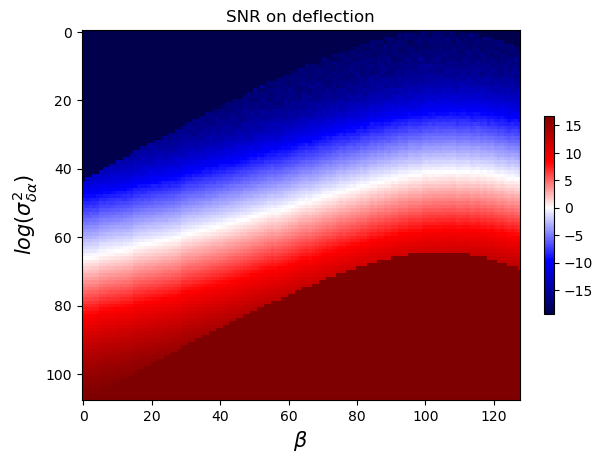

In [23]:
plt.imshow(SNR_def_matrix,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar(fraction=0.02)
plt.title('SNR on deflection')
plt.ylabel(r'$log(\sigma^2_{\delta \alpha})$',fontsize=15)
plt.xlabel(r'$\beta$',fontsize=15)

In [26]:
import scipy as sc
def plot_likelihood_custom(axis,X_array,Y_array,confidence_grid,manual_locations,fontsize=18):
    #Confidence levels
    #smooth the grid to avoid sharp edged contours
    smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid,sigma=(2,2))
    confidence_grid=smooth_confidence_grid
    
    imgConfidence=axis.contourf(X_array,Y_array,confidence_grid,[0,0.39347,0.86466,0.988891],colors=['red','indianred','rosybrown','w'],alpha=0.7)
    
    img=axis.contour(X_array,Y_array,confidence_grid,[0.39347,0.86466,0.988891],colors='k')

    #manual_locations=[(5,20)]
    clabel=axis.clabel(img,[0.988891],inline=True,fmt={0.988891: '$3\\sigma$'},fontsize=15,manual=manual_locations[0])
    #manual_locations=[(5,20)]
    clabel+=axis.clabel(img,[0.86466],inline=True,fmt={0.86466: '$2\\sigma$'},fontsize=15,manual=manual_locations[1])
    #manual_locations=[(5,20)]
    clabel+=axis.clabel(img,[0.39347],inline=True,fmt={0.39347: '$1\\sigma$'},fontsize=15,manual=manual_locations[2])
    
    for l in clabel:
        l.set_rotation(0)
    
    return axis,imgConfidence

Text(0, 0.5, '${\\rm log}(\\sigma^2_{\\delta \\alpha})$')

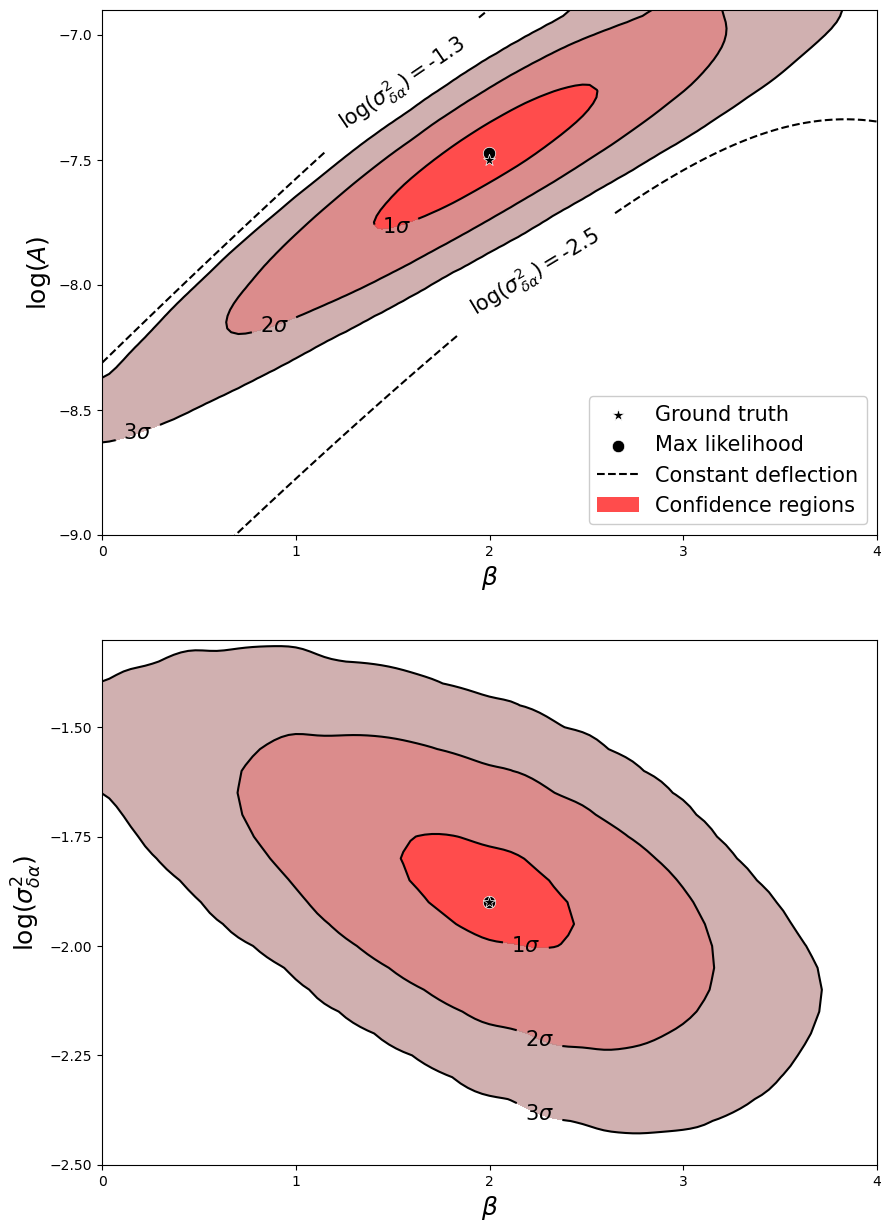

In [54]:
fig,axis=plt.subplots(2,1,figsize=(10,15))

manual_locations=[[(2.5,-17)],[(2.5,-14)],[(2,-10)]]

ax_top,imgConfidence=plot_likelihood_custom(axis[0],Beta_array,logA_array,combined_confidence[1],manual_locations)

def_lims=[-2.5,-1.3]
def_line=ax_top.contour(Beta_array,logA_array,log_Deflection,levels=def_lims,colors='k',linestyles='--')

clabel=ax_top.clabel(def_line,[def_lims[0]],inline=True,fmt={def_lims[0]: r'${\rm log}(\sigma^2_{\delta \alpha})=$'+'{:.1f}'.format(def_lims[0])},fontsize=15,manual=[(-2,-1)])
clabel=ax_top.clabel(def_line,[def_lims[1]],inline=True,fmt={def_lims[1]: r'${\rm log}(\sigma^2_{\delta \alpha})=$'+'{:.1f}'.format(def_lims[1])},fontsize=15,manual=[(-2,-2)])

true_logA_index,true_Beta_index=true_coords[1].astype(int)
pred_logA_index,pred_Beta_index=pred_coords[1].astype(int)

predPoint=ax_top.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Max likelihood',\
                         marker="o",s=80,color='k',edgecolor='w',linewidth=0.5)
truePoint=ax_top.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='Ground truth',\
                         marker="*",s=80,color='k',edgecolor='w',linewidth=0.5)

ax_top.set_xticks([0,1,2,3,4])
ax_top.set_yticks([-9,-8.5,-8,-7.5,-7])

ax_top.set_ylim(-9,logA_array[-1])
ax_top.set_xlim(0,4)

ax_top.set_xlabel(r'$\beta$',fontsize=FS)
ax_top.set_ylabel(r"${\rm log}(A)$",fontsize=FS)

l=ax_top.legend([truePoint,predPoint,def_line.collections[0],plt.Rectangle((1, 1), 2, 2, fc=imgConfidence.collections[0].get_facecolor()[0]),def_line],\
                ['Ground truth','Max likelihood','Constant deflection','Confidence regions'],loc='lower right',fontsize=15,framealpha=1)
for text in l.get_texts():
    text.set_color("k")



#manual_locations=[[(1.75,-17)],[(1.8,-17)],[(2,-10)]]
manual_locations=[[(1.6,-14)],[(1.76,-10)],[(2,-10)]]
ax_bot,_=plot_likelihood_custom(axis[1],Beta_array,logDef_array,combined_confidence_logDef[1],manual_locations)


#Prediction and truth
pred_logDef_index=np.argmin(np.abs(logDef_array-log_Deflection[pred_logA_index,pred_Beta_index]))
true_logDef_index=np.argmin(np.abs(logDef_array-log_Deflection[true_logA_index,true_Beta_index]))
    
predPoint=ax_bot.scatter(Beta_array[pred_Beta_index],logDef_array[pred_logDef_index],label='Max likelihood',\
                         marker="o",s=80,color='k',edgecolor='w',linewidth=0.5)
truePoint=ax_bot.scatter(Beta_array[true_Beta_index],logDef_array[true_logDef_index],label='Ground truth',\
                         marker="*",s=80,color='k',edgecolor='w',linewidth=0.5)

ax_bot.set_xticks([0,1,2,3,4])
ax_bot.set_yticks([-2.5,-2.25,-2,-1.75,-1.5])

ax_bot.set_ylim(def_lims[0],def_lims[1])
ax_bot.set_xlim(0,4)

ax_bot.set_xlabel(r'$\beta$',fontsize=FS)
ax_bot.set_ylabel(r'${\rm log}(\sigma^2_{\delta \alpha})$',fontsize=FS)

# Biases and uncertainties

## Max likelihood bias

In [1613]:
from GRF_perturbations.Modules.Inference import get_likelihood,compute_Confidence_grid
def compute_predictions_seeds(spectra_F_row,MU_tensor,Sigma_tensor):

    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,MU_tensor,Sigma_tensor),spectra_F_row)
    
    res=jax_map(lambda likelihood: jnp.array(jnp.unravel_index(jnp.argmax(likelihood),(128,128))),likelihoods)
    
    return res

compute_Predictions_Betas= jax.jit(lambda spectra_BF_row: jax_map(lambda spectra_F_row: compute_predictions_seeds(spectra_F_row,MU_tensor,Sigma_tensor),spectra_BF_row))
compute_Predictions_grid_mapped=jax.jit(lambda spectra_ABF_grid: jax_map(compute_Predictions_Betas,spectra_ABF_grid))

import time
#Reports index of the point predicted by Max Likelihood estimator
start_time=time.time()
#maxL_predictions_grid=compute_Predictions_grid_mapped(Spectra_grid)
#np.savez('../Processing_scripts/results/prediction/Max_Likelihood_prediction',maxL_predictions_grid)
print(time.time()-start_time)

3.0994415283203125e-05


In [1614]:
def confidence_in_point(likelihood,raveled_index):
    
    Probability_normalisation=likelihood.sum()
    
    A_index,B_index=jnp.unravel_index(raveled_index,(128,128))
    likelihood_level=likelihood[A_index,B_index]
    
    likelihood_above_index=jnp.where(likelihood>=likelihood_level,likelihood,np.zeros((128,128)))
    
    Probability_within_index_contour=likelihood_above_index.sum()
    
    return Probability_within_index_contour/Probability_normalisation

def jax_map_with_index(f, xs, raveled_index,index_step):
  scan_func = lambda row_index,x: (row_index+index_step,f(x,raveled_index+row_index))
  #Jaxified loop over an array
  ys=jax.lax.scan(scan_func,0,xs)[1]
  return ys

def compute_confidence_seeds(spectra_F_row,raveled_index,MU_tensor,Sigma_tensor):

    confidence_retrieval_func=lambda likelihood: confidence_in_point(likelihood,raveled_index)
    
    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,MU_tensor,Sigma_tensor),spectra_F_row)
    
    res=jax_map(confidence_retrieval_func,likelihoods)
    
    return res

map_seeds_pure=jax.jit(lambda spectra_F_row,raveled_index: compute_confidence_seeds(spectra_F_row,raveled_index,MU_tensor,Sigma_tensor))
map_Betas_pure=jax.jit(lambda spectra_BF_row,raveled_index: jax_map_with_index(map_seeds_pure,spectra_BF_row,raveled_index,index_step=1))
map_logAs_pure=jax.jit(lambda spectra_ABF_row: jax_map_with_index(map_Betas_pure,spectra_ABF_row,0,index_step=128))

import time
start_time=time.time()
#Reports confidence in the ground truth point. Needed to make max Likelihood bias plot in units of normalised error
#maxL_confidence_in_bias=map_logAs_pure(Spectra_grid)
#np.savez('../Processing_scripts/results/prediction/Max_Likelihood_confidence_in_bias',maxL_confidence_in_bias)
print(time.time()-start_time)

2.8133392333984375e-05


In [1615]:
maxL_predictions_grid=np.load('../Processing_scripts/results/prediction/Max_Likelihood_prediction.npz')['arr_0']
maxL_confidence_in_bias=np.load('../Processing_scripts/results/prediction/Max_Likelihood_confidence_in_bias.npz')['arr_0']

#Change it to multivariate normal with 0.39347,0.86466,0.988891
'''
def confidence_to_sigma(confidence):
    one_sided_confidence=0.5+confidence/2
    return sc.stats.norm.ppf(one_sided_confidence)

'''

def confidence_to_sigma(confidence):
    return np.sqrt(-2*np.log(1-confidence))


maxL_sigmas_in_bias=np.vectorize(confidence_to_sigma)(maxL_confidence_in_bias)

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))
true_indices=np.array([np.arange(0,len(logA_array)),np.arange(0,len(Beta_array))])

predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2),dtype='float')

#if bias to one side is opposite to the other side border neglect it 
def neglect_outofbounds_index_amp(predicted_index,true_index):
    
    bias_limit=np.minimum(true_index,127-true_index)
    bias=float(predicted_index-true_index)
    
    if np.abs(bias)>bias_limit:
        return np.nan
    else:
        return bias

vect_index_correction=np.vectorize(neglect_outofbounds_index_amp)
    
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):

        logA_bias=(maxL_predictions_grid[i,j,:,0]-i)
        
        
        predicted_bias[i,j,:,0]=vect_index_correction(maxL_predictions_grid[i,j,:,0],i)
        predicted_bias[i,j,:,1]=vect_index_correction(maxL_predictions_grid[i,j,:,1],j)
        
        nan_mask=np.isnan(predicted_bias[i,j,:,0])&np.isnan(predicted_bias[i,j,:,1])
        predicted_bias[i,j,nan_mask,:]=[np.nan,np.nan]
        
        #predicted_bias[i,j,:,0]=maxL_predictions_grid[i,j,:,0]-i
        #predicted_bias[i,j,:,1]=maxL_predictions_grid[i,j,:,1]-j
        
        

mean_bias=np.nanmean(predicted_bias,axis=-2)
mean_bias_normalised_amp=maxL_sigmas_in_bias.mean(axis=-1)


#mean_normalised_bias=(predicted_bias/).mean(axis=-2)
#std_bias=(predicted_bias).std(axis=-2)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_37147/329352623.py:53: RuntimeWarning: Mean of empty slice
  mean_bias=np.nanmean(predicted_bias,axis=-2)


In [1618]:
maxL_sigmas_in_bias.max()

3.2902209746350968

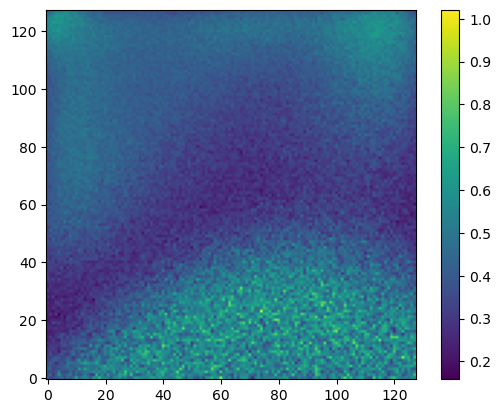

In [1619]:
plt.imshow(maxL_sigmas_in_bias.mean(axis=-1))
plt.gca().invert_yaxis()
plt.colorbar()

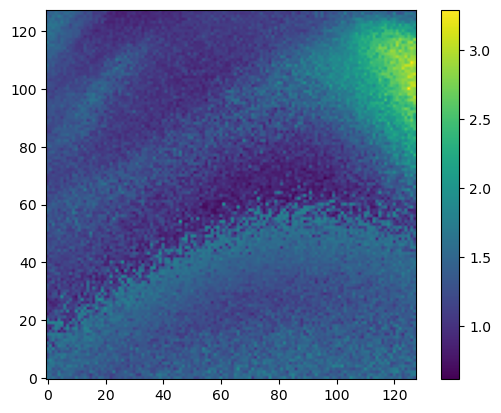

In [1620]:
plt.imshow(maxL_sigmas_in_bias.max(axis=-1))
plt.gca().invert_yaxis()
plt.colorbar()

In [1594]:
k_grid,nonsingular_k_grid=get_k_grid(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
power_sum_func=np.vectorize(lambda beta: np.power(nonsingular_k_grid,-beta+2).sum())
Amplitudes,Deflection_power_sums=np.meshgrid(power_sum_func(Beta_array),np.power(10,logA_array))
Deflection_variance=Amplitudes*Deflection_power_sums

In [1610]:
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

red_patch = mpatches.Patch(color='red', label='The red data')

def make_maxL_bias_figure(axis,mean_bias,mean_bias_normalised_amp,img_arr,manual_locations,limit_bias=1,limit_quiver=0.5,quiver_step=5,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):
    
    Bias_amplitude=mean_bias_normalised_amp
    Bias_amplitude[Bias_amplitude>limit_bias]=limit_bias
    
    arrow_color=mpl.cm.get_cmap('magma')(0)
    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)
    
    #Bias background image
    img_arr+=[axis.imshow(Bias_amplitude,cmap='magma_r',alpha=1,label='Bias amplitude')]
    imgarr=axis.arrow(0,0,0,0,color='k',alpha=1)
    
    #Contours of bias
    smooth_amplitude=sc.ndimage.gaussian_filter(Bias_amplitude,1,mode='constant')
    #imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='k',linewidths=linewidths)
    
    
    #Quiver
    complex_vector=(mean_bias[:,:,1]+1j*mean_bias[:,:,0])
    angle=np.angle(complex_vector)
    
    amp=mean_bias_normalised_amp
    I_quiver=np.cos(angle)*amp
    J_quiver=np.sin(angle)*amp
    
    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)
    
    I_quiver=sc.ndimage.gaussian_filter(I_quiver,sigma=(quiver_step,quiver_step),mode='mirror')
    J_quiver=sc.ndimage.gaussian_filter(J_quiver,sigma=(quiver_step,quiver_step),mode='mirror')
    
    quiver_index=np.append(np.arange(0,128,quiver_step),[126])
    X,Y=np.meshgrid(quiver_index,quiver_index)
    
    #scale=20,width=0.0015,headwidth=7,headlength=7.5,pivot='middle'
    imgquiver=axis.quiver(X,Y,I_quiver[Y,X], J_quiver[Y,X],label='Bias direction',color=arrow_color,**quiver_kwargs)
    
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
    imgSNR=axis.contourf(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[SNR_grid.min(),0],colors='grey',alpha=0.5)
    
    
    #Legend
    yellow_patch = mpatches.Patch(color=mpl.cm.get_cmap('magma_r')(0.2))
    axis.legend([yellow_patch,imgarr,plt.Rectangle((1, 1), 2, 2, fc=imgSNR.collections[0].get_facecolor()[0])], ['Bias amplitude','Bias direction',r'$SNR \leq 0$'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='w')
    
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    #X axis
    axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title('Bias of maximum likelihood prediction',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0,0.25,0.5,0.75,1],fraction=0.03)
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    
    #cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['0',r'$0.25\sigma$',r'$0.5\sigma$',r'$0.75\sigma$',r'$1 \sigma$'])
    
    return img_arr

In [1624]:
mean_bias_normalised_amp[SNR_grid>0].max()

0.6411088707763041

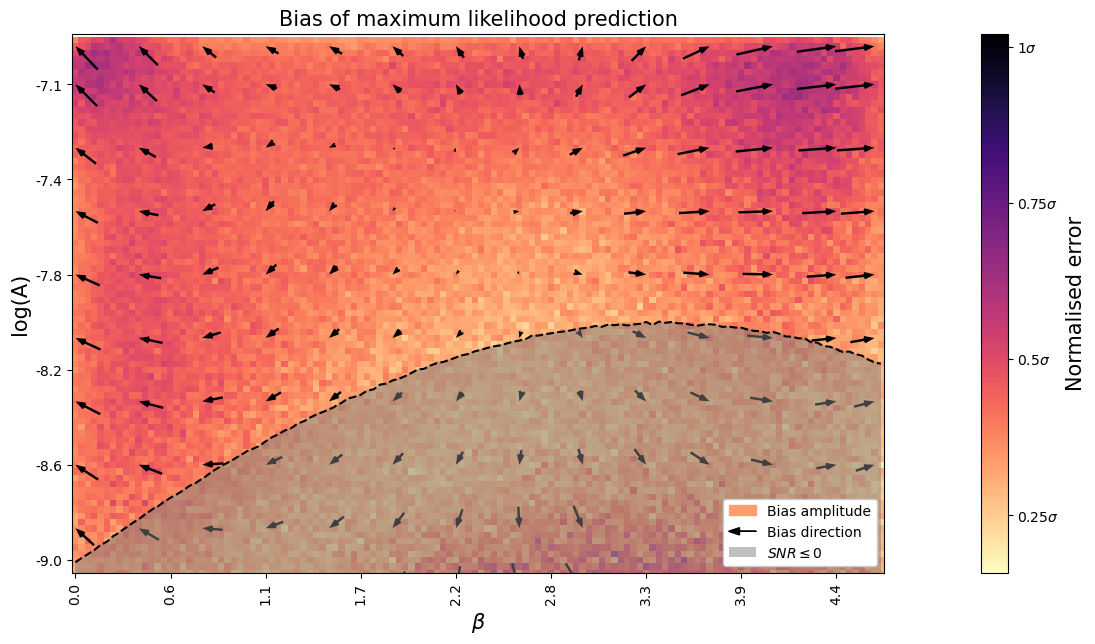

In [1611]:
import scipy as sc
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(100,100)],[(90,60)]]
img_arr=make_maxL_bias_figure(ax,mean_bias,mean_bias_normalised_amp,img_arr,manual_locations,\
                              limit_bias=10,limit_quiver=0,quiver_step=10,labels_fontsize=15,\
                              quiver_kwargs={'scale':10,'width':0.003,'headwidth':3,'headlength':4,'pivot':'tip','minlength':0})

#ax.contour(np.log10(Deflection_variance),levels=20,colors='k',linestyles='-',linewidths=0.5)

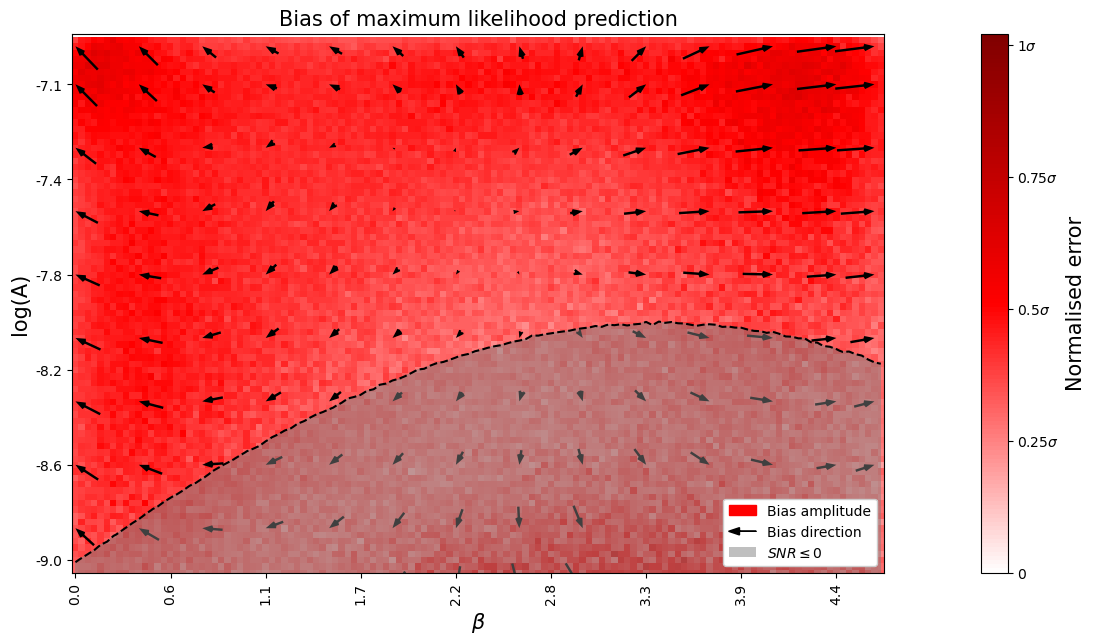

In [1308]:
import scipy as sc
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(100,100)],[(90,60)]]
img_arr=make_maxL_bias_figure(ax,mean_bias,mean_bias_normalised_amp,img_arr,manual_locations,\
                              limit_bias=10,limit_quiver=0,quiver_step=10,labels_fontsize=15,\
                              quiver_kwargs={'scale':10,'width':0.003,'headwidth':3,'headlength':4,'pivot':'tip','minlength':0})

#ax.contour(np.log10(Deflection_variance),levels=20,colors='k',linestyles='-',linewidths=0.5)

## Marginalized likelihoods biases

In [53]:
Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [54]:
'''Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)'''

"Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']\n\nfor i in range(1,4):\n    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)"

In [55]:
predicted_indices=Prediction_grid[:,:,:,0]
logA_confidence_regions=Prediction_grid[:,:,:,1:4]
Beta_confidence_regions=Prediction_grid[:,:,:,4:]

In [56]:
predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2))

uncertainty_width=np.zeros((len(logA_array),len(Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        #(sigma_top+sigma_bot)/2
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width/2
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width/2
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-i)
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-j)
        

mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)
std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

In [12]:
pred=Beta_array[predicted_indices[90,54,:,1]].mean()
up_conf=Beta_array[Beta_confidence_regions[90,54,:,0,1]].mean()
low_conf=Beta_array[Beta_confidence_regions[90,54,:,0,0]].mean()
print(pred,up_conf-pred,pred-low_conf)

2.0321023622047245 0.8630236220472436 0.8585826771653544


In [57]:
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))

images=[np.sqrt(I**2+J**2),std_bias[:,:,0],std_bias[:,:,1]]
titles=[r'$\mu$',r'$\sigma_{logA}$',r'$\sigma_{\beta}$']

## Combined bias (probably incorrect)

In [83]:
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import scipy as sc

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

'''
#imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='k',linewidths=linewidths)
    
    
    #Quiver
    complex_vector=(mean_bias[:,:,1]+1j*mean_bias[:,:,0])
    angle=np.angle(complex_vector)
    
    amp=mean_bias_normalised_amp
    I_quiver=np.cos(angle)*amp
    J_quiver=np.sin(angle)*amp
    
    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)
    
    I_quiver=sc.ndimage.gaussian_filter(I_quiver,sigma=(quiver_step,quiver_step),mode='mirror')
    J_quiver=sc.ndimage.gaussian_filter(J_quiver,sigma=(quiver_step,quiver_step),mode='mirror')
    
    quiver_index=np.append(np.arange(0,128,quiver_step),[126])
    X,Y=np.meshgrid(quiver_index,quiver_index)
    
    #scale=20,width=0.0015,headwidth=7,headlength=7.5,pivot='middle'
    imgquiver=axis.quiver(X,Y,I_quiver[Y,X], J_quiver[Y,X],label='Bias direction',color=arrow_color,**quiver_kwargs)
'''
def make_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_bias=1,limit_quiver=0.5,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):
    
    I=mean_bias[:,:,1]
    J=mean_bias[:,:,0]
    Bias_amplitude=np.sqrt(I**2+J**2)
    Bias_amplitude[Bias_amplitude>limit_bias]=limit_bias
    
    arrow_color=mpl.cm.get_cmap('magma_r')(0)
    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)
    
    
    #Bias background image
    #img_arr+=[axis.imshow(Bias_amplitude,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]
    img_arr+=[axis.imshow(Bias_amplitude,cmap='magma_r',alpha=1,label='Bias amplitude')]
    
    
    #Contours of bias
    smooth_amplitude=sc.ndimage.gaussian_filter(Bias_amplitude,1,mode='constant')
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='k',linewidths=linewidths)
    #imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='w',linewidths=linewidths)
    
    
    
    #manual_locations=[(5,20)]
    clabels=axis.clabel(imgCont,[0.5],inline=True,fmt={0.5: '$0.5\\sigma$'},fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.25],inline=True,fmt={0.25: '$0.25\\sigma$'},fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)
    
    #Quiver
    step=20
    mask_quiver=Bias_amplitude>limit_quiver
    I_quiver=mask_quiver*I
    J_quiver=mask_quiver*J
    #scale=20,width=0.0015,headwidth=7,headlength=7.5,pivot='middle'
    
    imgquiver=axis.quiver(X[::step,::step],Y[::step,::step],I_quiver[::step,::step], J_quiver[::step,::step],label='Bias direction',color=arrow_color,**quiver_kwargs)


    
    #SNR contour
    #imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
    #imgSNR=axis.contourf(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[SNR_grid.min(),0],colors='grey',alpha=0.5)
    
    #Legend
    yellow_patch = mpatches.Patch(color=arrow_color)
    axis.legend([yellow_patch,imgarr], ['Bias amplitude','Bias direction'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='k',labelcolor='w')
    
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    #X axis
    axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title('Bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0,0.25,0.5,0.75,1],fraction=0.03)
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels(['0',r'$0.25\sigma$',r'$0.5\sigma$',r'$0.75\sigma$',r'$1 \sigma$'])
    
    return img_arr

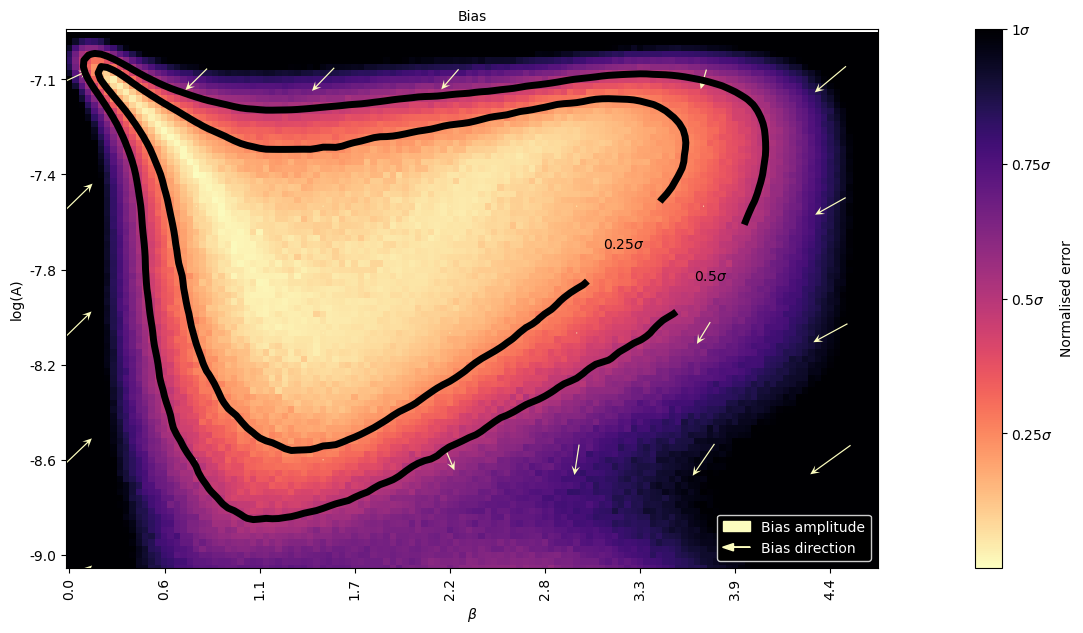

In [82]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(100,100)],[(90,60)]]
img_arr=make_bias_figure(ax,mean_bias,img_arr,manual_locations,limit_bias=1,
                         quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'mid'})

## Seprate bias

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32054/445659114.py:23: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')


(43.0, 128.0)

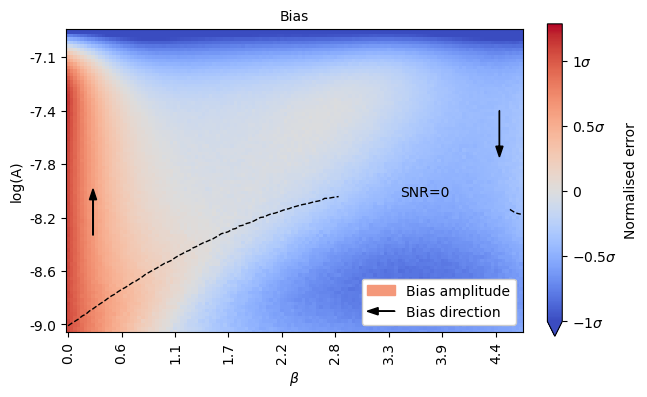

In [137]:
limit_bias=1;limit_quiver=0.5;limit_amplitude=-9;\
clabel_fontsize=10;labels_fontsize=10;inline_spacing=70;linewidths=5;\
quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}
manual_locations=[[(100,100)],[(90,60)]]


fig,axis=plt.subplots(1,1)


In [58]:
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import scipy as sc
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

red_patch = mpatches.Patch(color='red', label='The red data')

def make_logA_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):
    
    logA_bias=mean_bias[:,:,0]

    #arrow_color=mpl.cm.get_cmap('k')(0)
    arrow_color='k'
    imgarr=axis.arrow(12,95-5,0,7,head_width=2,color=arrow_color,alpha=1)
    axis.arrow(116,95+5,0,-7,head_width=2,color=arrow_color,alpha=1)
    
    

    
    #Bias background image
    img_arr+=[axis.imshow(logA_bias,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0,-1,logA_bias.max()),alpha=1,label='Bias amplitude')]

    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                             fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)


    #Legend
    yellow_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.75))
    axis.legend([yellow_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='w',labelcolor='k')
    
    labelstep=15
    
    
    
    #Y axis
    axis.invert_yaxis()
    
    
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    
    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)
    
    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title('log(A) bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,fraction=0.03,ticks=[-1,-0.5,0,0.5,1],extend='min')
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels([r'$-1 \sigma$',r'$-0.5\sigma$','0',r'$0.5\sigma$',r'$1 \sigma$'])
    
    
    axis.set_ylim(np.argmin(np.abs(logA_array-(-9))),128)
    
    
    return img_arr

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32054/1574146817.py:20: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')


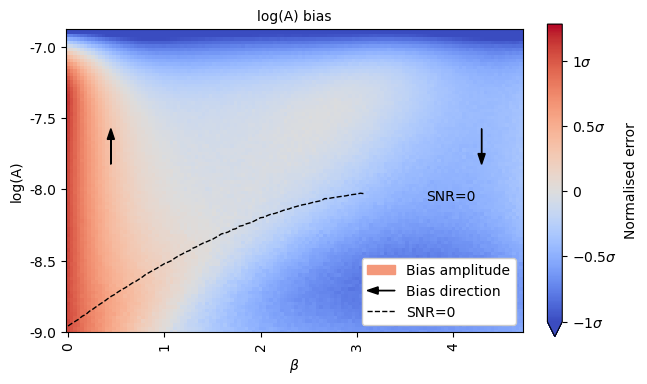

In [264]:
fig,axis=plt.subplots(1,1)

img_arr=[]
img_arr=make_logA_bias_figure(axis,mean_bias,img_arr,manual_locations)

In [68]:
def make_Beta_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):
    
    Beta_bias=mean_bias[:,:,1]

    #arrow_color=mpl.cm.get_cmap('k')(0)
    arrow_color='k'
    imgarr=axis.arrow(12-5,95,7,0,head_width=2,color=arrow_color,alpha=1)
    axis.arrow(116+5,95,-7,0,head_width=2,color=arrow_color,alpha=1)
    
    

    
    #Bias background image
    img_arr+=[axis.imshow(Beta_bias,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0,Beta_bias.min(),1),alpha=1,label='Bias amplitude')]

    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                             fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)


    #Legend
    yellow_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.75))
    axis.legend([yellow_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='w',labelcolor='k')
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks([])
    '''
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)
    '''
    
    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)
    
    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title(r'$\beta$'+' bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[-1,-0.5,0,0.5,1],fraction=0.03,extend='max')
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels([r'$-1 \sigma$',r'$-0.5\sigma$','0',r'$0.5\sigma$',r'$1 \sigma$'])
    
    
    axis.set_ylim(np.argmin(np.abs(logA_array-(-9))),128)
    
    return img_arr

NameError: name 'manual_locations' is not defined

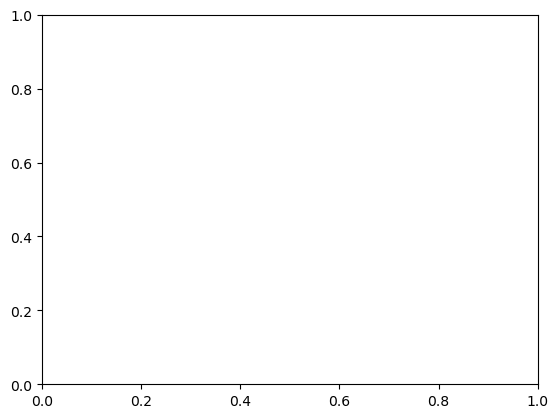

In [60]:
fig,axis=plt.subplots(1,1)

img_arr=[]
img_arr=make_Beta_bias_figure(axis,mean_bias,img_arr,manual_locations)

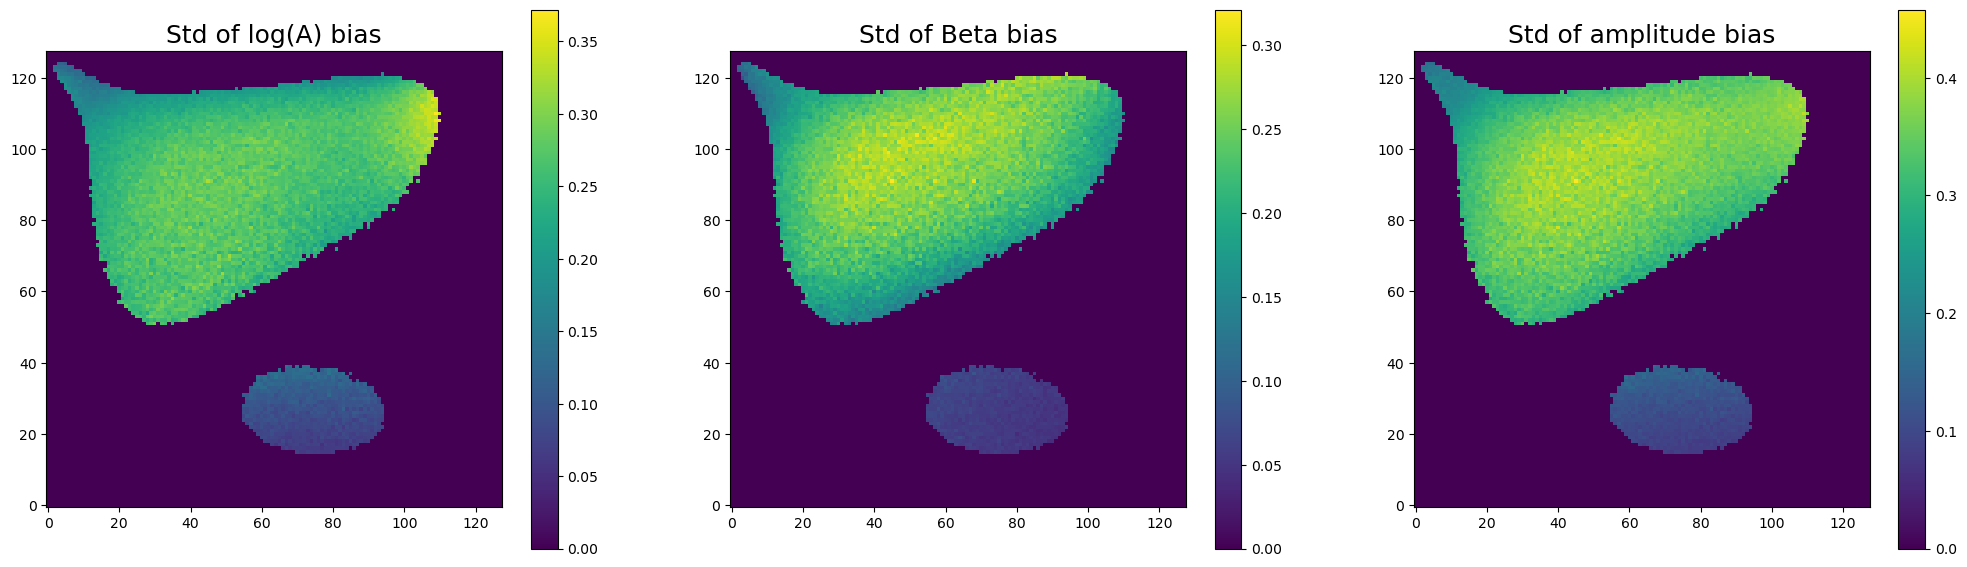

In [31]:
fig,ax=plt.subplots(1,3,figsize=(25,7))

mask_unbiased_reg=np.sqrt(mean_bias[:,:,0]**2+mean_bias[:,:,1]**2)<0.5

im=ax[0].imshow(std_bias[:,:,0]*mask_unbiased_reg)
fig.colorbar(im,ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Std of log(A) bias',fontsize=FS)

im=ax[1].imshow(std_bias[:,:,1]*mask_unbiased_reg)
fig.colorbar(im,ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Std of Beta bias',fontsize=FS)

im=ax[2].imshow(np.sqrt(std_bias[:,:,0]**2+std_bias[:,:,1]**2)*mask_unbiased_reg)
fig.colorbar(im,ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_title('Std of amplitude bias',fontsize=FS)
plt.show()

In [32]:
(np.sqrt(std_bias[:,:,0]**2+std_bias[:,:,1]**2)*mask_unbiased_reg).max()

0.4578301648739839

In [19]:
std_bias.shape

(128, 128, 2)

# Uncertainties

In [63]:
from matplotlib.legend_handler import HandlerTuple
from skimage import measure
def make_logA_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):
    
    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,0,sigma-1]*(logA_array[1]-logA_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty

    
    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty,0.2),alpha=0.75)]
    
    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.3,0.35],colors='k',linewidths=linewidths)
    
    clabels=axis.clabel(imgCont,[0.35],inline=True,fmt={0.35: '$\\sigma=0.35$'},\
                        fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.3],inline=True,fmt={0.3: '$\\sigma=0.3$'},\
                fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.25],inline=True,fmt={0.25: '$\\sigma=0.25$'},\
                fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                         fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    #axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    #axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    
    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)
    
    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)
    
    #Title and colorbar
    axis.set_title('log(A) uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.25,0.35,0.45,0.6],fraction=0.03,extend='min')
    cbar.ax.set_ylabel('log(A) units',rotation=90,fontsize=labels_fontsize,labelpad=5)
    
    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('seismic')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{log(A)}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{log(A)}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')

    
    
    return img_arr

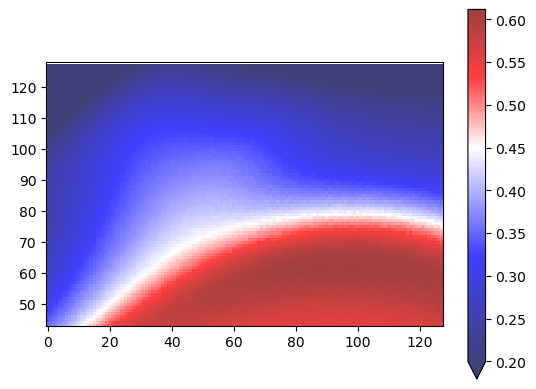

In [30]:
sigma=1
Uncertainty=uncertainty_width.mean(axis=2)[:,:,0,sigma-1]*(logA_array[1]-logA_array[0])
plt.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0.45,0.2),alpha=0.75)
plt.gca().invert_yaxis()
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)
plt.colorbar(extend='min')

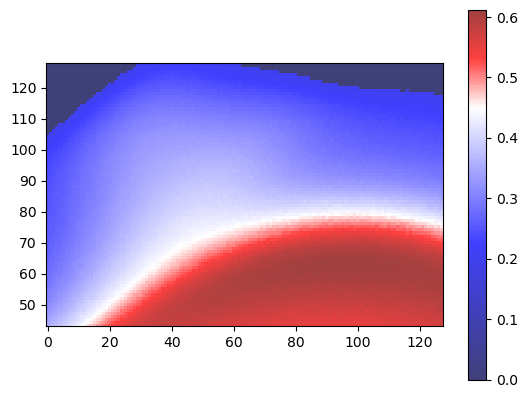

In [29]:
sigma=1
Uncertainty=uncertainty_width.mean(axis=2)[:,:,0,sigma-1]*(logA_array[1]-logA_array[0])
mask_lim=(Uncertainty>0.2)
plt.imshow(Uncertainty*mask_lim,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0.45),alpha=0.75)
plt.gca().invert_yaxis()
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)
plt.colorbar()

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32054/2055176658.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


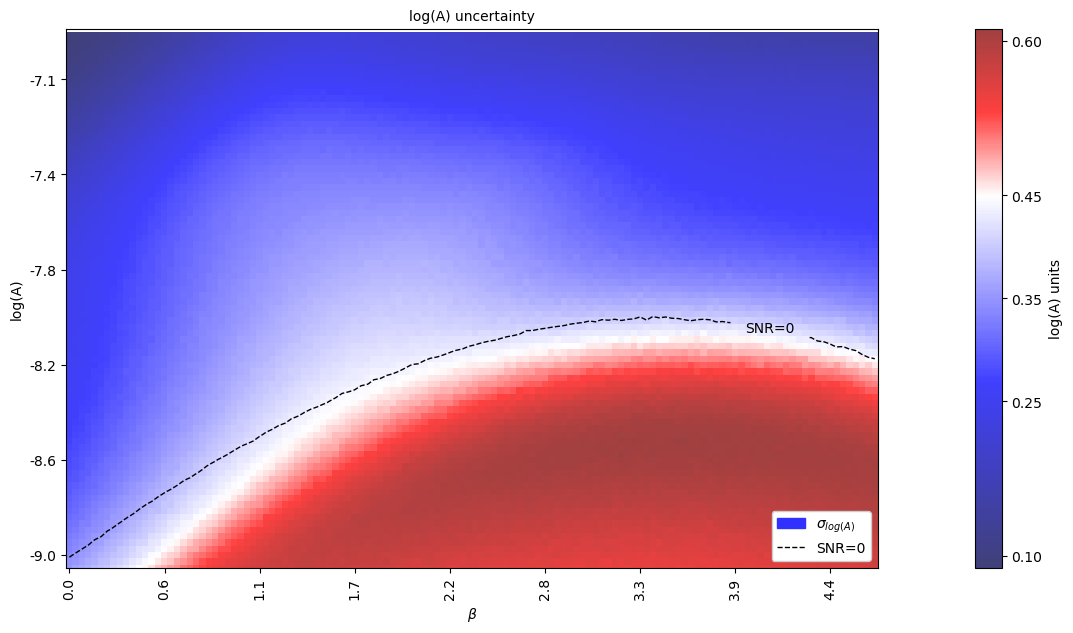

In [249]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(110,60)],[(110,60)],[(110,60)],[(110,60)]]
img_arr=make_logA_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_37147/2089398391.py:32: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


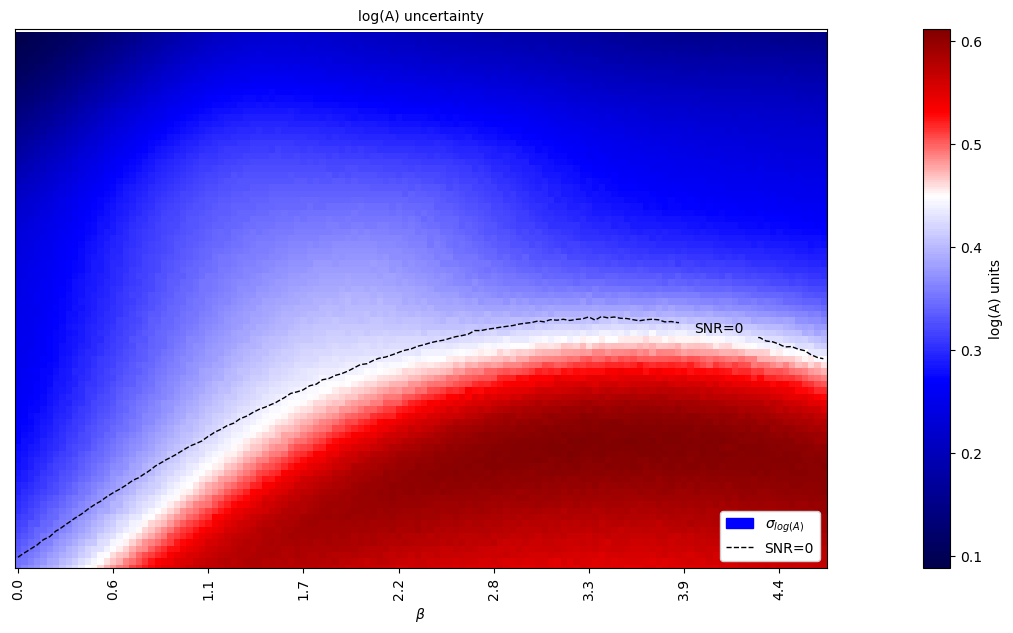

In [1480]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(110,60)],[(110,60)],[(110,60)],[(110,60)]]
img_arr=make_logA_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1)

In [67]:
def make_Beta_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):
    
    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty

    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty,0.35),alpha=0.75)]
    
    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[-2:,:]=Uncertainty[-2:,:]
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.5,0.7,0.9],colors='k',linewidths=linewidths)
    
    clabels=axis.clabel(imgCont,[0.9],inline=True,fmt={0.9: '$\\sigma=0.9$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.7],inline=True,fmt={0.7: '$\\sigma=0.7$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.5],inline=True,fmt={0.5: '$\\sigma=0.5$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths)
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                          fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks([])
    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    '''
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)
    '''
    
    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)
    
    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)
    
    #Title and colorbar
    axis.set_title(r'$\beta$'+' uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.4,0.6,0.8,1,1.2,1.4],fraction=0.03,extend='min')
    cbar.ax.set_ylabel(r'$\beta$'+' units',rotation=90,fontsize=labels_fontsize,labelpad=5)
    
    
    cbar.ax.set_yticklabels(['0.4','0.6','0.8','1','1.2','1.4'])
    
    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('seismic')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{\beta}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{\beta}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    
    return img_arr

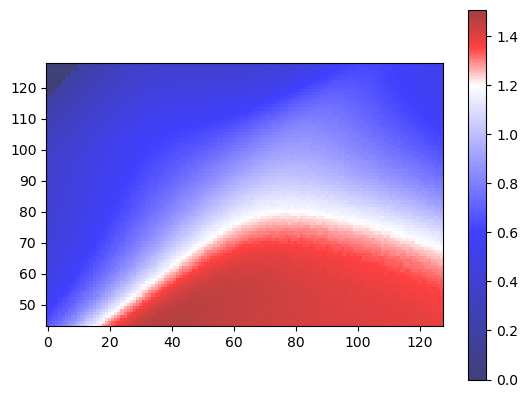

In [33]:
sigma=1
Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
mask_lim=(Uncertainty>0.2)
plt.imshow(Uncertainty*mask_lim,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(1.2),alpha=0.75)
plt.gca().invert_yaxis()
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)
plt.colorbar()

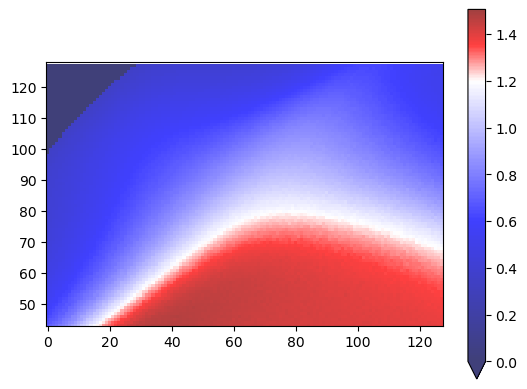

In [41]:
sigma=1
Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
mask_lim=(Uncertainty>0.35)
plt.imshow(Uncertainty*mask_lim,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(1.2),alpha=0.75)
plt.gca().invert_yaxis()
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)
plt.colorbar(extend='min')

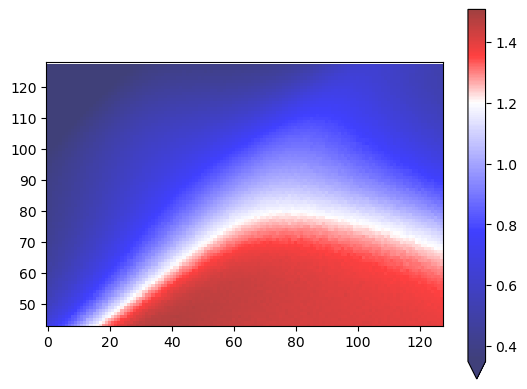

In [38]:
sigma=1
Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
mask_lim=(Uncertainty>0.3)
plt.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(1.2,0.35),alpha=0.75)
plt.gca().invert_yaxis()
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)
plt.colorbar(extend='min')

In [1641]:
Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,0]*(Beta_array[1]-Beta_array[0])
Uncertainty[SNR>0].mean()

1.065709699014979

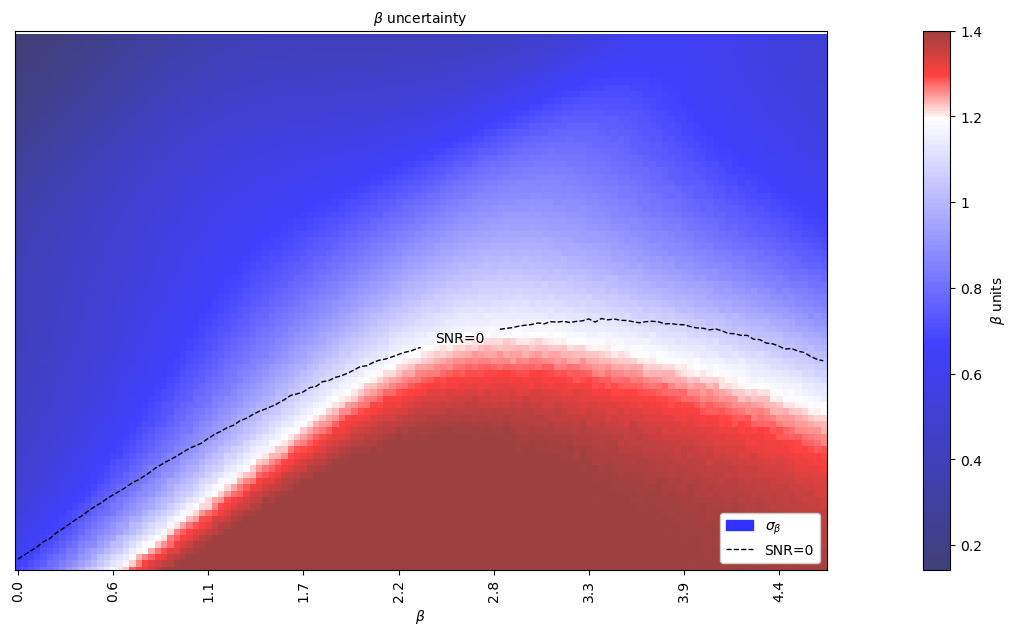

In [247]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(70,60)],[(70,60)],[(70,60)],[(70,60)]]
img_arr=make_Beta_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_28338/1514860680.py:36: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_28338/2749572916.py:20: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_28338/2614747110.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


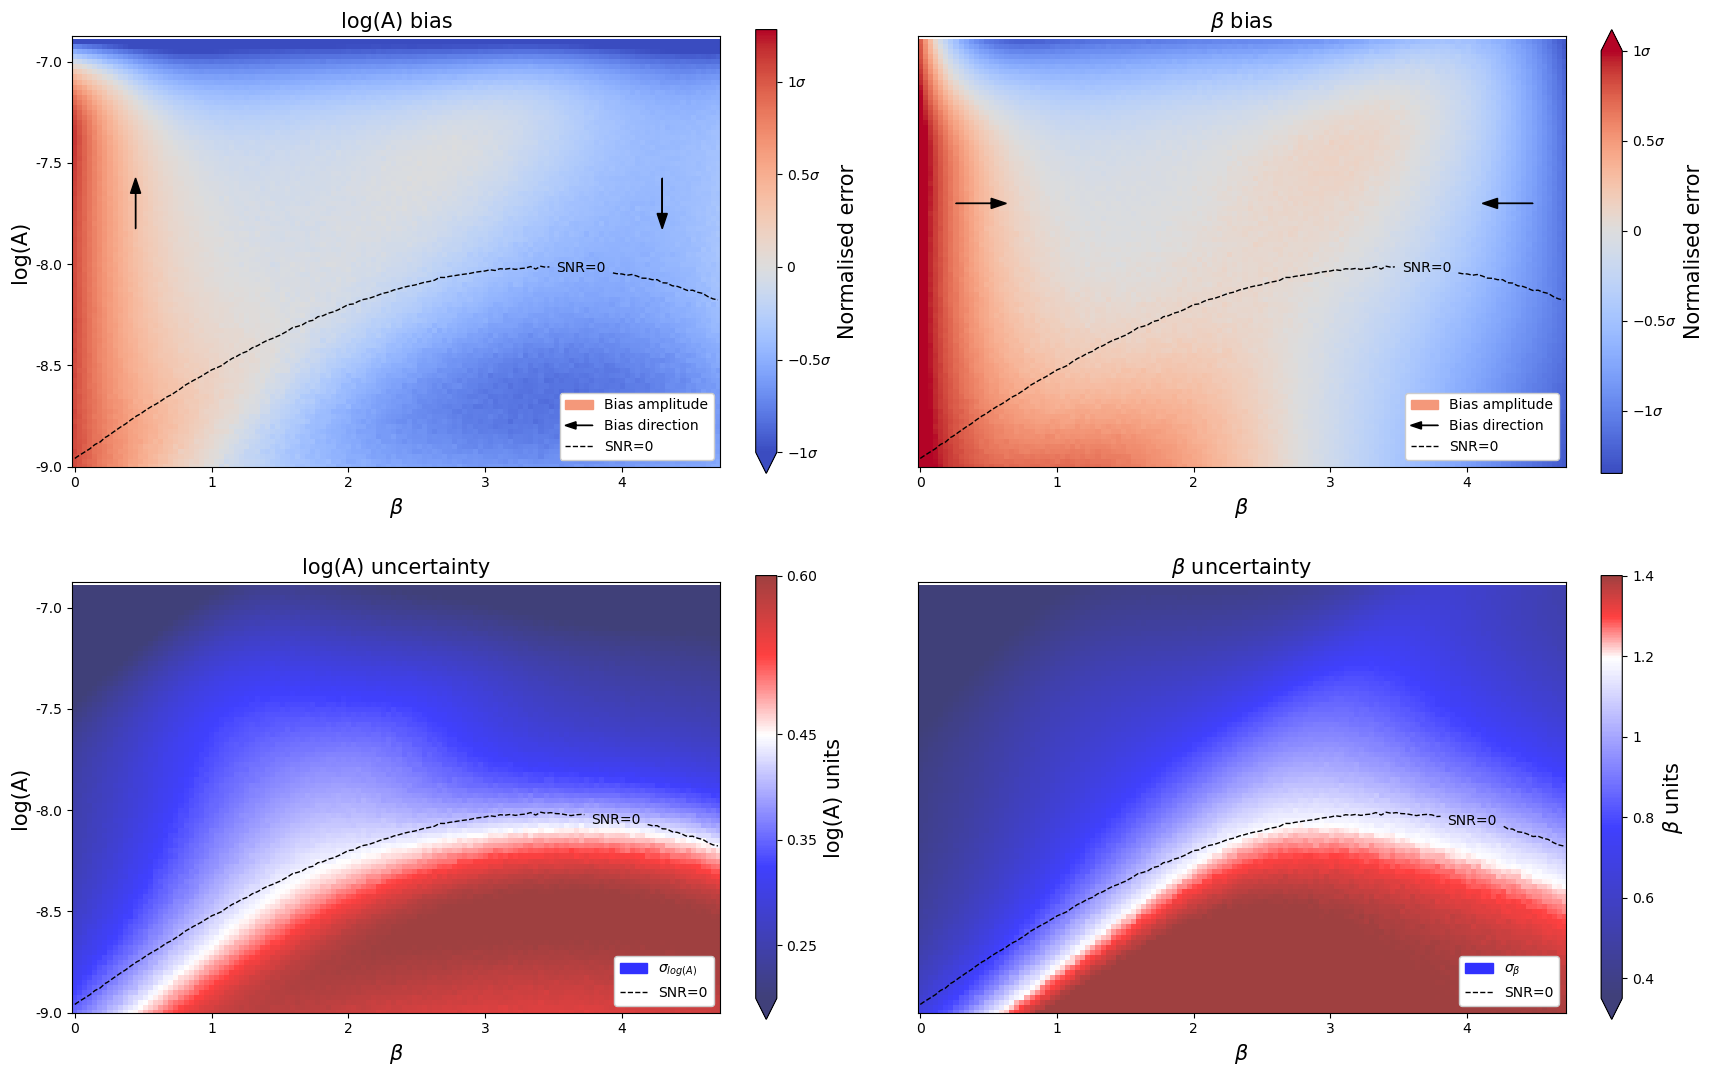

In [69]:
fig,ax=plt.subplots(2,2,figsize=(20,13))

img_arr=[]

manual_locations=[[(100,99)],[(100,90)]]
img_arr=make_logA_bias_figure(ax[0,0],mean_bias,img_arr,manual_locations,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)


manual_locations=[[(100,99)],[(100,90)]]
img_arr=make_Beta_bias_figure(ax[0,1],mean_bias,img_arr,manual_locations,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(105,60)],[(100,60)],[(90,60)],[(105,60)]]
img_arr=make_logA_uncertainty_figure(ax[1,0],uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(107,70)],[(88,70)],[(95,80)],[(108,60)]]
img_arr=make_Beta_uncertainty_figure(ax[1,1],uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

#fig.tight_layout(w_pad=3)
plt.show()

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_37147/137702383.py:32: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


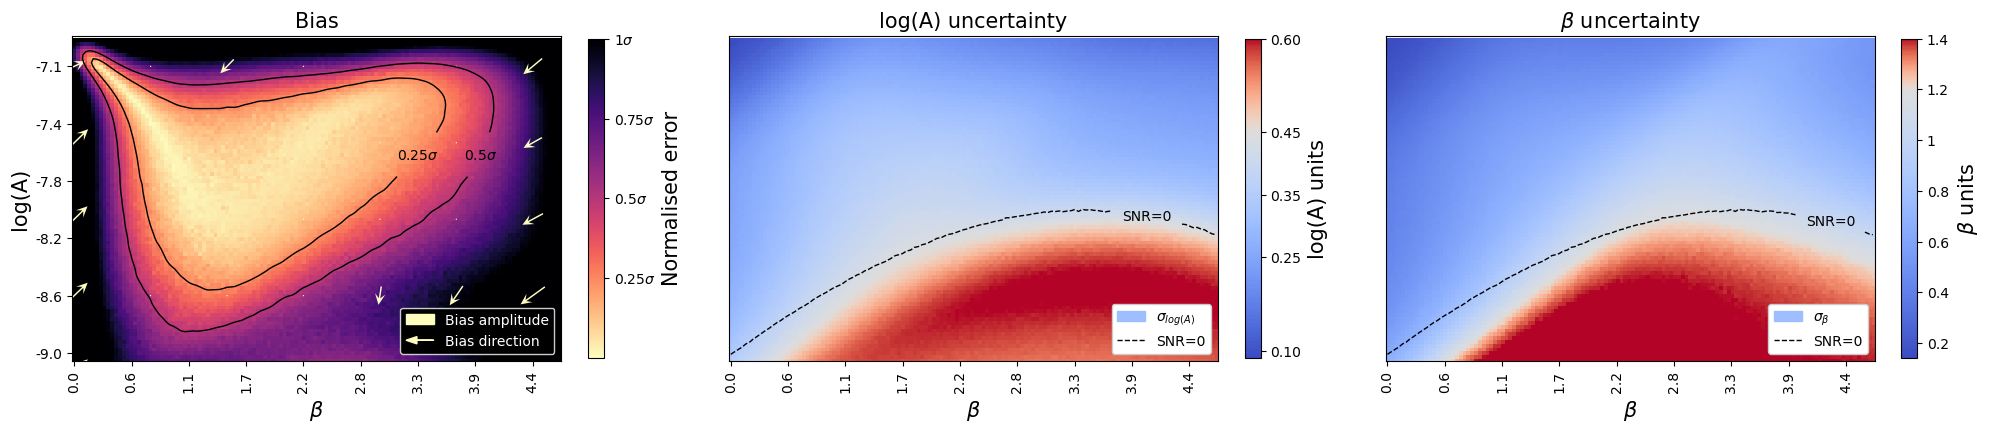

In [1590]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

img_arr=[]

manual_locations=[[(100,99)],[(100,90)]]
quiver_kwargs={'scale':20,'width':0.003,'headwidth':7,'headlength':7.5,'pivot':'mid'}
img_arr=make_bias_figure(ax[0],mean_bias,img_arr,manual_locations,limit_bias=1,limit_quiver=0.75,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1,quiver_kwargs=quiver_kwargs)

manual_locations=[[(105,60)],[(100,60)],[(90,60)],[(105,60)]]
img_arr=make_logA_uncertainty_figure(ax[1],uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(107,70)],[(88,70)],[(95,80)],[(108,60)]]
img_arr=make_Beta_uncertainty_figure(ax[2],uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

fig.tight_layout(w_pad=3)
plt.show()

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_37147/2089398391.py:32: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


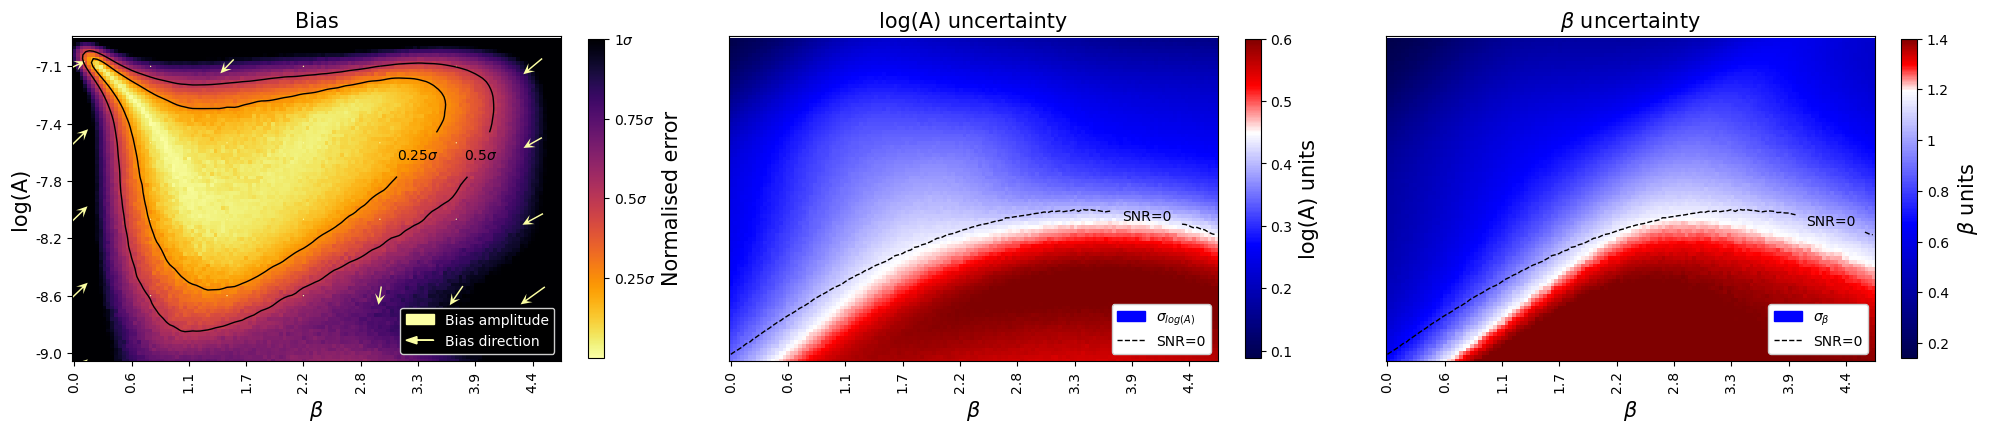

In [1566]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

img_arr=[]

manual_locations=[[(100,99)],[(100,90)]]
quiver_kwargs={'scale':20,'width':0.003,'headwidth':7,'headlength':7.5,'pivot':'mid'}
img_arr=make_bias_figure(ax[0],mean_bias,img_arr,manual_locations,limit_bias=1,limit_quiver=0.75,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1,quiver_kwargs=quiver_kwargs)

manual_locations=[[(105,60)],[(100,60)],[(90,60)],[(105,60)]]
img_arr=make_logA_uncertainty_figure(ax[1],uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(107,70)],[(88,70)],[(95,80)],[(108,60)]]
img_arr=make_Beta_uncertainty_figure(ax[2],uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

fig.tight_layout(w_pad=3)
plt.show()